## Part 1: Pulse Rate Algorithm

### Contents
Fill out this notebook as part of your final project submission.

**You will have to complete both the Code and Project Write-up sections.**
- The [Code](#Code) is where you will write a **pulse rate algorithm** and already includes the starter code.
   - Imports - These are the imports needed for Part 1 of the final project. 
     - [glob](https://docs.python.org/3/library/glob.html)
     - [numpy](https://numpy.org/)
     - [scipy](https://www.scipy.org/)
- The [Project Write-up](#Project-Write-up) to describe why you wrote the algorithm for the specific case.


### Dataset
You will be using the **Troika**[1] dataset to build your algorithm. Find the dataset under `datasets/troika/training_data`. The `README` in that folder will tell you how to interpret the data. The starter code contains a function to help load these files.

1. Zhilin Zhang, Zhouyue Pi, Benyuan Liu, ‘‘TROIKA: A General Framework for Heart Rate Monitoring Using Wrist-Type Photoplethysmographic Signals During Intensive Physical Exercise,’’IEEE Trans. on Biomedical Engineering, vol. 62, no. 2, pp. 522-531, February 2015. Link

-----

### Code

In [19]:
#!conda install matplotlib -y
# !conda install -c conda-forge librosa -y
# !pip install mpld3

In [1]:
import matplotlib.pyplot as plt
import mpld3
import pandas as pd
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import glob

import numpy as np
import scipy as sp
import scipy.io
import scipy.signal as sps
# np.warnings.filterwarnings('ignore')

In [10]:
!pwd

/Users/eshaankirpal/Desktop/healthcareAI/5.Applying_AI_to_Wearable_Device_Data/nd320-c4-wearable-data-project-starter/part_1


In [53]:

def LoadTroikaDataset():
    """
    Retrieve the .mat filenames for the troika dataset.

    Review the README in ./datasets/troika/ to understand the organization of the .mat files.

    Returns:
        data_fls: Names of the .mat files that contain signal data
        ref_fls: Names of the .mat files that contain reference data
        <data_fls> and <ref_fls> are ordered correspondingly, so that ref_fls[5] is the 
            reference data for data_fls[5], etc...
    """
    data_dir = "../assets/datasets-part1/troika/training_data"
    data_fls = sorted(glob.glob(data_dir + "/DATA_*.mat"))
    ref_fls = sorted(glob.glob(data_dir + "/REF_*.mat"))
    return data_fls, ref_fls

def LoadTroikaDataFile(data_fl):
    """
    Loads and extracts signals from a troika data file.

    Usage:
        data_fls, ref_fls = LoadTroikaDataset()
        ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[0])

    Args:
        data_fl: (str) filepath to a troika .mat file.

    Returns:
        numpy arrays for ppg, accx, accy, accz signals.
    """
    data = sp.io.loadmat(data_fl)['sig']
    return data[2:]

def BandpassFilter(signal, fs=125):
    """Bandpass filter the signal between 5 and 15 Hz."""
    b, a = sps.butter(3, (40/60, 240/60), btype='bandpass', fs=fs)
    return sps.filtfilt(b, a, signal)

def MovingSum(signal, fs=300):
    """Moving sum operation with window size of 150ms."""
    n_samples = int(round(fs * 0.150))
    return pd.Series(signal).rolling(n_samples, center=True).sum().values

def AggregateErrorMetric(pr_errors, confidence_est):
    """
    Computes an aggregate error metric based on confidence estimates.

    Computes the MAE at 90% availability. 

    Args:
        pr_errors: a numpy array of errors between pulse rate estimates and corresponding 
            reference heart rates.
        confidence_est: a numpy array of confidence estimates for each pulse rate
            error.

    Returns:
        the MAE at 90% availability
    """
    # Higher confidence means a better estimate. The best 90% of the estimates
    #    are above the 10th percentile confidence.
    percentile90_confidence = np.percentile(confidence_est, 10)

    # Find the errors of the best pulse rate estimates
    best_estimates = pr_errors[confidence_est >= percentile90_confidence]

    # Return the mean absolute error
    return np.mean(np.abs(best_estimates))

def Evaluate():
    """
    Top-level function evaluation function.

    Runs the pulse rate algorithm on the Troika dataset and returns an aggregate error metric.

    Returns:
        Pulse rate error on the Troika dataset. See AggregateErrorMetric.
    """
    # Retrieve dataset files
    data_fls, ref_fls = LoadTroikaDataset()
    errs, confs = [], []
    for data_fl, ref_fl in zip(data_fls, ref_fls):
        # Run the pulse rate algorithm on each trial in the dataset
        errors, confidence = RunPulseRateAlgorithm(data_fl, ref_fl)
        errs.append(errors)
        confs.append(confidence)
        # Compute aggregate error metric
    errs = np.hstack(errs)
    confs = np.hstack(confs)
    return AggregateErrorMetric(errs, confs)

def RunPulseRateAlgorithm(data_fl, ref_fl):
    # Load data using LoadTroikaDataFile
    ppg, accx, accy, accz = LoadTroikaDataFile(data_fl)

    # Compute pulse rate estimates and estimation confidence.
    
    #Load PPG and Accelerometer Signals.  Get Freqs and FFT Spectra for PPG and Accelerometer signals.
    fs=125
    nfft_window = fs*8
    noverlap = fs*6
    
    filtered_ppg = BandpassFilter(ppg)
    filt_ppg_specs, filt_ppg_freqs,_,filt_ppg_im = plt.specgram(filtered_ppg, NFFT = nfft_window, Fs=fs, noverlap=noverlap)
    plt.close()
    
    filtered_accx = BandpassFilter(accx)
    accx_specs, accx_freqs,_,_ = plt.specgram(filtered_accx, NFFT = nfft_window, Fs=fs, noverlap=noverlap)
    plt.close()
    
    filtered_accy = BandpassFilter(accy)
    accy_specs, accy_freqs,_,_ = plt.specgram(filtered_accy, NFFT = nfft_window, Fs=fs, noverlap=noverlap)
    plt.close()
    
    filtered_accz = BandpassFilter(accz)
    accz_specs, accz_freqs,_,_ = plt.specgram(filtered_accz, NFFT = nfft_window, Fs=fs, noverlap=noverlap)
    plt.close()
      
    """
    Compute pulse Rate Estimates.  
    distance_bpm is the maximum distance between Accelerometers (x,y,and z) frequency and PPG frequency 
        that will be considered to be too similar. This can occur if arm movements have strong contribution
        to PPG signals.
    distance_bps converts the distance_bpm from per minute to per second(Hz).
    Compare up to 10 PPG frequencies that potentially represent the pulse rate to find one that is not 
    similar to accx, accy, or accz.  
    If none found, select the frequency with largest magnitude.
    """
    
    ppg_max_freqs = []
    distance_bpm = 10 # Hyperparameter that was tested from 5 BPM to 20 BPM
    distance_bps = distance_bpm/60 # Conversion 1 Hz = 1 cycles per minute * (1 min/60 s)
    count=0
    inner=0
    for i in range(filt_ppg_specs.shape[1]):
        accx_max_freq = accx_freqs[np.argmax(accx_specs[:,i])]
        accy_max_freq = accy_freqs[np.argmax(accy_specs[:,i])]
        accz_max_freq = accz_freqs[np.argmax(accz_specs[:,i])]
        sorted_ppg_specs = np.sort(filt_ppg_specs[:,i])[::-1]
        count += 1
        #for f in range(filt_ppg_specs.shape[0]):
        for f in range(10):
            ppg_freq = filt_ppg_freqs[np.argwhere(filt_ppg_specs == (sorted_ppg_specs[f]))[0][0]]
            inner+=1
            if ppg_freq == 0:
                continue
            elif (np.abs(ppg_freq-accx_max_freq)<=distance_bps) or (np.abs(ppg_freq-accy_max_freq)<=distance_bps) or (np.abs(ppg_freq-accz_max_freq)<=distance_bps):
                #if f == (filt_ppg_specs.shape[0]-1):
                if f == 9:
                    ppg_max_freqs.append(filt_ppg_freqs[np.argwhere(filt_ppg_specs == (sorted_ppg_specs[0]))[0][0]])
                continue
            else:
                ppg_max_freqs.append(ppg_freq)
                break
    #print(f'Count: {count}, Inner: {inner}, ppg_max_freqs: {len(ppg_max_freqs)}')            

    
    """
    Compute Confidence Estimation:
    - For this computation, The energy in the frequency spectrum that is concentrated near the pulse rate estimate is
    determined by summing the frequency spectrum around the pulse rate estimate with a window of bpm_sum_window.
    - The bpm_sum_window will be chosen to be less than the performance criterion of 15BPM difference 
    between estimated pulse rate and reference pulse rate.
    - The Confidence Estimate is the Energy around the Pulse Rate Estimate divided by the sum of the 
    entire frequency spectrum.
    """
    
    bpm_sum_window = 10 # Hyperparameter that can be tuned. Currently 10 BPM
    bps_sum_window = bpm_sum_window/60 # Conversion 1 Hz = 1 per minute * (1 min/60 s)
    
    ecgdata = sp.io.loadmat(ref_fl)['BPM0']
    
    confidences = []
    for i in range(filt_ppg_specs.shape[1]):
        low_window = ppg_max_freqs[i]-bps_sum_window 
        high_window = ppg_max_freqs[i] + bps_sum_window
        window = (filt_ppg_freqs>= low_window) & (filt_ppg_freqs<=high_window)
        confidence=np.sum(filt_ppg_specs[:,i][window])/np.sum(filt_ppg_specs[:,i])
        error = np.abs(ppg_max_freqs[i]*60-ecgdata[i][0])
        confidences.append((i, ppg_max_freqs[i]*60, ecgdata[i][0], confidence, error))

    confidence_df = pd.DataFrame(
                    data=confidences, 
                    columns=['WindowNumber','Estimated_Pulse_Rate','Ref_BPM','Confidence','Error'])
    
    # Return per-estimate mean absolute error and confidence as a 2-tuple of numpy arrays.
  
    errors = confidence_df['Error'].values
    confidence = confidence_df['Confidence'].values
    
    return errors, confidence
    

In [3]:
data_fls, ref_fls = LoadTroikaDataset()
data_fls,ref_fls

(['../assets/datasets-part1/troika/training_data/DATA_01_TYPE01.mat',
  '../assets/datasets-part1/troika/training_data/DATA_02_TYPE02.mat',
  '../assets/datasets-part1/troika/training_data/DATA_03_TYPE02.mat',
  '../assets/datasets-part1/troika/training_data/DATA_04_TYPE01.mat',
  '../assets/datasets-part1/troika/training_data/DATA_04_TYPE02.mat',
  '../assets/datasets-part1/troika/training_data/DATA_05_TYPE02.mat',
  '../assets/datasets-part1/troika/training_data/DATA_06_TYPE02.mat',
  '../assets/datasets-part1/troika/training_data/DATA_07_TYPE02.mat',
  '../assets/datasets-part1/troika/training_data/DATA_08_TYPE02.mat',
  '../assets/datasets-part1/troika/training_data/DATA_10_TYPE02.mat',
  '../assets/datasets-part1/troika/training_data/DATA_11_TYPE02.mat',
  '../assets/datasets-part1/troika/training_data/DATA_12_TYPE02.mat'],
 ['../assets/datasets-part1/troika/training_data/REF_01_TYPE01.mat',
  '../assets/datasets-part1/troika/training_data/REF_02_TYPE02.mat',
  '../assets/datasets

In [18]:
ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[8])
len(ppg),len(accx),len(accy), len(accz)

(40803, 40803, 40803, 40803)

In [54]:
Evaluate()

11.290899036682845

## Data Exploration

In [5]:
fs=125

In [6]:
df_data=[]
for i in range(len(data_fls)):
    sig=sp.io.loadmat(data_fls[i])['sig']
#    ref=sp.io.loadmat(ref_fls[i])['BPM0'].flatten()
    df_tmp=pd.DataFrame(
                        {'ecg1':sig[0],'ecg2':sig[1],
                         'ppg':sig[2],'accx':sig[3],
                         'accy':sig[4],'accz':sig[5],
                        #'ref': ref
                        }
    )
    df_data.append(df_tmp)
df_data[0]

ecg1   ecg2    ppg    accx    accy    accz
0     -269.5  -23.0    4.0 -0.0702  0.3432  0.9594
1     -267.5  -24.0    6.0 -0.0702  0.3588  0.9438
2     -267.5  -26.5    3.0 -0.0546  0.3666  0.9360
3     -265.5  -27.0    3.5 -0.0468  0.3666  0.9360
4     -262.0  -30.0    0.0 -0.0468  0.3744  0.9126
...      ...    ...    ...     ...     ...     ...
37932 -164.0   31.5   44.5  0.4134 -0.2652  0.7176
37933 -175.0   48.5   66.5  0.4212 -0.2730  0.7176
37934 -188.5   67.0   86.0  0.4134 -0.2808  0.7254
37935 -209.0   84.5  104.0  0.4134 -0.2730  0.7176
37936 -232.0  100.0  118.5  0.4134 -0.2730  0.7254

[37937 rows x 6 columns]

In [7]:
data = sp.io.loadmat(ref_fls[3])
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Fri Jan 02 15:14:46 2015',
 '__version__': '1.0',
 '__globals__': [],
 'BPM0': array([[ 82.873],
        [ 79.318],
        [ 71.278],
        [ 66.667],
        [ 66.298],
        [ 71.128],
        [ 77.231],
        [ 77.945],
        [ 76.967],
        [ 74.503],
        [ 75.758],
        [ 80.043],
        [ 83.841],
        [ 87.58 ],
        [ 90.164],
        [ 91.362],
        [ 91.565],
        [ 92.489],
        [ 91.362],
        [ 88.805],
        [ 87.58 ],
        [ 87.953],
        [ 91.463],
        [ 95.376],
        [ 97.72 ],
        [ 97.508],
        [ 98.039],
        [ 99.693],
        [100.784],
        [102.632],
        [103.175],
        [102.389],
        [100.784],
        [ 97.72 ],
        [ 96.257],
        [ 96.257],
        [ 95.486],
        [ 96.463],
        [ 95.847],
        [ 96.051],
        [ 95.541],
        [ 94.719],
        [ 90.659],
        [ 87.394],
        [ 84.746]

In [8]:
data,shapes=[],[]
for data_fl,ref_fl in zip(data_fls,ref_fls):
    ppg, accx, accy, accz = LoadTroikaDataFile(data_fl)
    bpm = sp.io.loadmat(ref_fl)['BPM0']
    data.append((ppg,accx,accy,accz,bpm))
    shapes.append((ppg.shape[0],accx.shape[0],accy.shape[0],accz.shape[0],bpm.shape[0],ppg.shape[0]/fs))
    
print("Data shapes:")
shapes

Data shapes:


[(37937, 37937, 37937, 37937, 148, 303.496),
 (37850, 37850, 37850, 37850, 148, 302.8),
 (35989, 35989, 35989, 35989, 140, 287.912),
 (27576, 27576, 27576, 27576, 107, 220.608),
 (37250, 37250, 37250, 37250, 146, 298.0),
 (37328, 37328, 37328, 37328, 146, 298.624),
 (38373, 38373, 38373, 38373, 150, 306.984),
 (36650, 36650, 36650, 36650, 143, 293.2),
 (40803, 40803, 40803, 40803, 160, 326.424),
 (38042, 38042, 38042, 38042, 149, 304.336),
 (36500, 36500, 36500, 36500, 143, 292.0),
 (37316, 37316, 37316, 37316, 146, 298.528)]

In [9]:
len(data),len(data[0])

(12, 5)

In [26]:
%matplotlib tk

In [27]:
mpld3.enable_notebook()

In [10]:
speed_change_time=[0.5,1.5,2.5,3.5,4.5]
speed_change_time_in_fs=[x*60*fs for x in speed_change_time]
speed_change_time_in_fs

[3750.0, 11250.0, 18750.0, 26250.0, 33750.0]

In [11]:
def get_sensor_signals(data, record_num):
    """
    data: list of dataframes
    record_num: integer
    """
    assert record_num < len(data), "Record Num out of bounds"
    record=data[record_num]
    ppg= record[0]
    accx=record[1]
    accy=record[2]
    accz=record[3]
    ref=record[4]
    
    return ppg,accx,accy,accz,ref

                ppg          accx          accy          accz
count  40803.000000  40803.000000  40803.000000  40803.000000
mean       6.089577      0.034362      0.887629      0.278592
std       50.464443      0.285988      0.884642      0.496081
min     -205.000000     -0.990600     -0.600600     -1.310400
25%      -24.000000     -0.179400      0.234000      0.007800
50%        3.500000      0.070200      0.709800      0.366600
75%       33.000000      0.257400      1.232400      0.655200
max      266.000000      0.889200      3.985800      1.934400


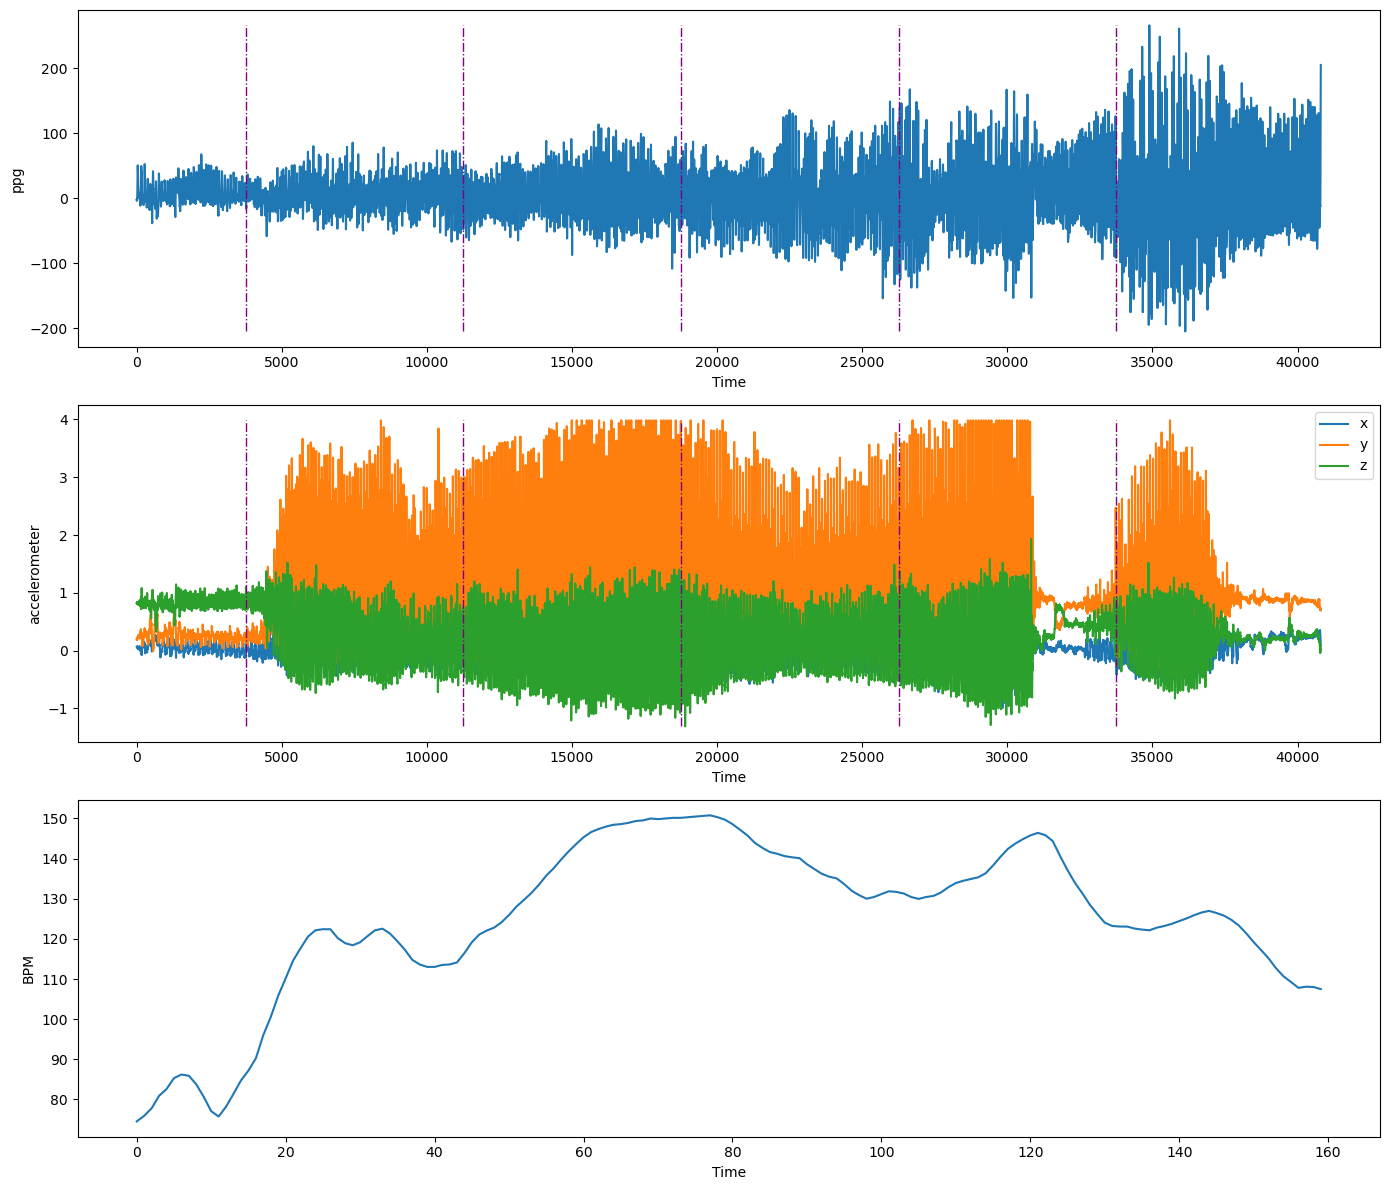

In [15]:
idx=8
ppg,accx,accy,accz,bpm=get_sensor_signals(data,idx)
df_record=pd.DataFrame({'ppg':ppg,'accx':accx,'accy':accy,'accz':accz})

ts=np.arange(ppg.shape[0])
ts2=np.arange(bpm.shape[0])
fig, axs = plt.subplots(3, 1,figsize=(14,12))

axs[0].plot(ts,ppg)
axs[0].set_xlabel('Time')
axs[0].set_ylabel('ppg')
axs[0].vlines(x=speed_change_time_in_fs, ymin=ppg.min(),ymax=ppg.max(),colors='purple', ls='-.', lw=1)
#axs[0].grid(True)

axs[1].plot(ts, accx, label='x')
axs[1].plot(ts, accy, label='y')
axs[1].plot(ts, accz, label='z')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('accelerometer')
#axs[1].grid(True)
axs[1].legend()
axs[1].vlines(x=speed_change_time_in_fs, ymin=min(accx.min(),accy.min(),accz.min()),ymax=max(accx.max(),accy.max(),accz.max()),colors='purple', ls='-.', lw=1)

axs[2].plot(ts2,bpm)
axs[2].set_xlabel('Time')
axs[2].set_ylabel('BPM')
#axs[2].grid(True)

fig.tight_layout()
#print(data_fls[idx])
print(df_record.describe())

Text(0, 0.5, 'ppg')

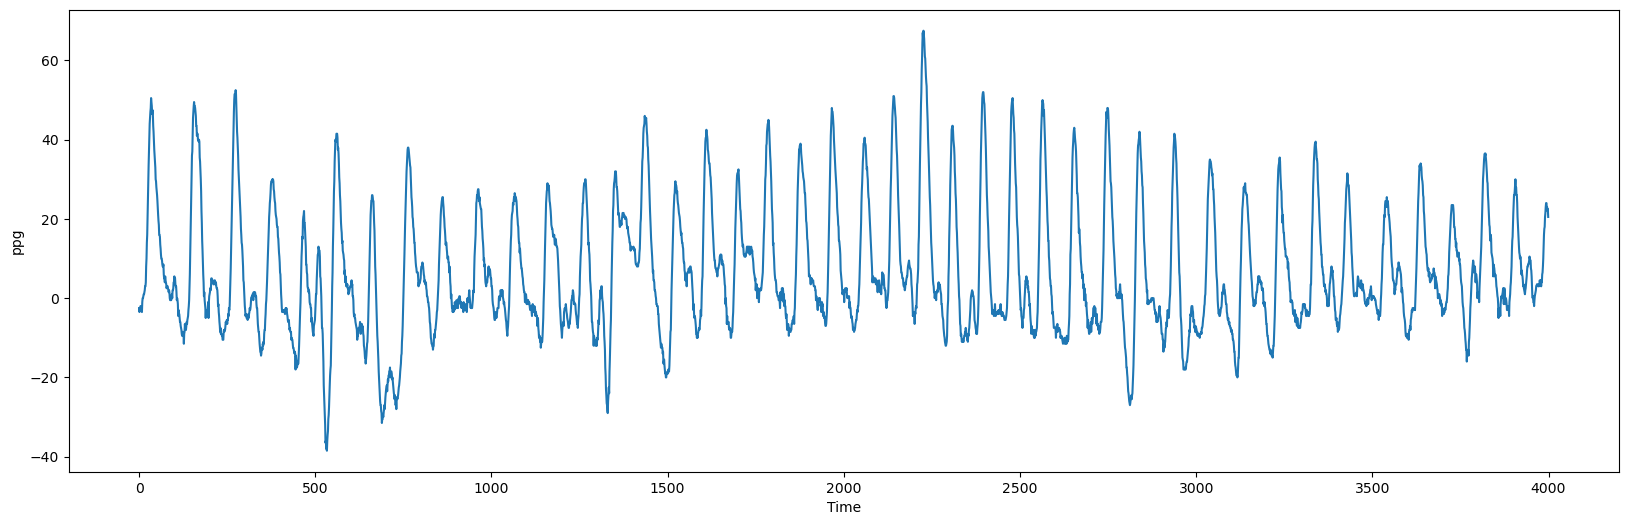

In [16]:
plt.figure(figsize=(20,6))
plt.plot(ts[:4000],ppg[:4000])
plt.xlabel('Time')
plt.ylabel('ppg')

Text(0, 0.5, 'ppg')

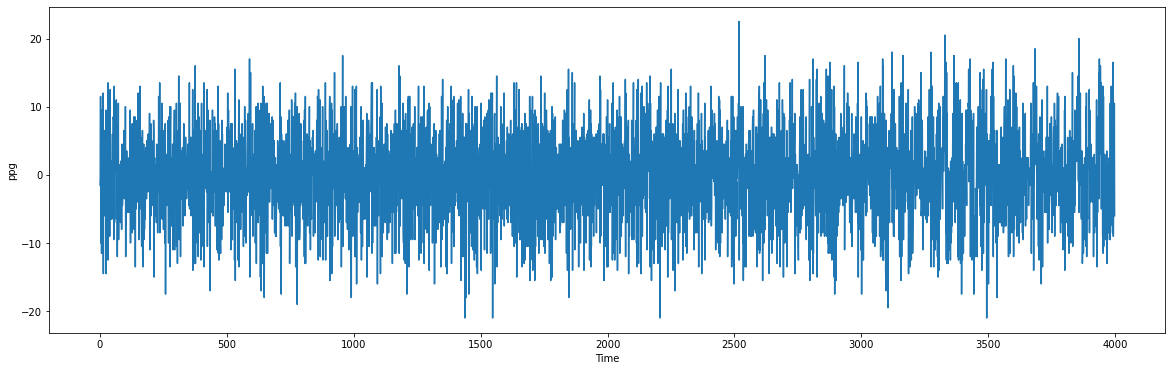

In [75]:
plt.figure(figsize=(20,6))
plt.plot(ts[:3999],np.diff(ppg[:4000]))
plt.xlabel('Time')
plt.ylabel('ppg')

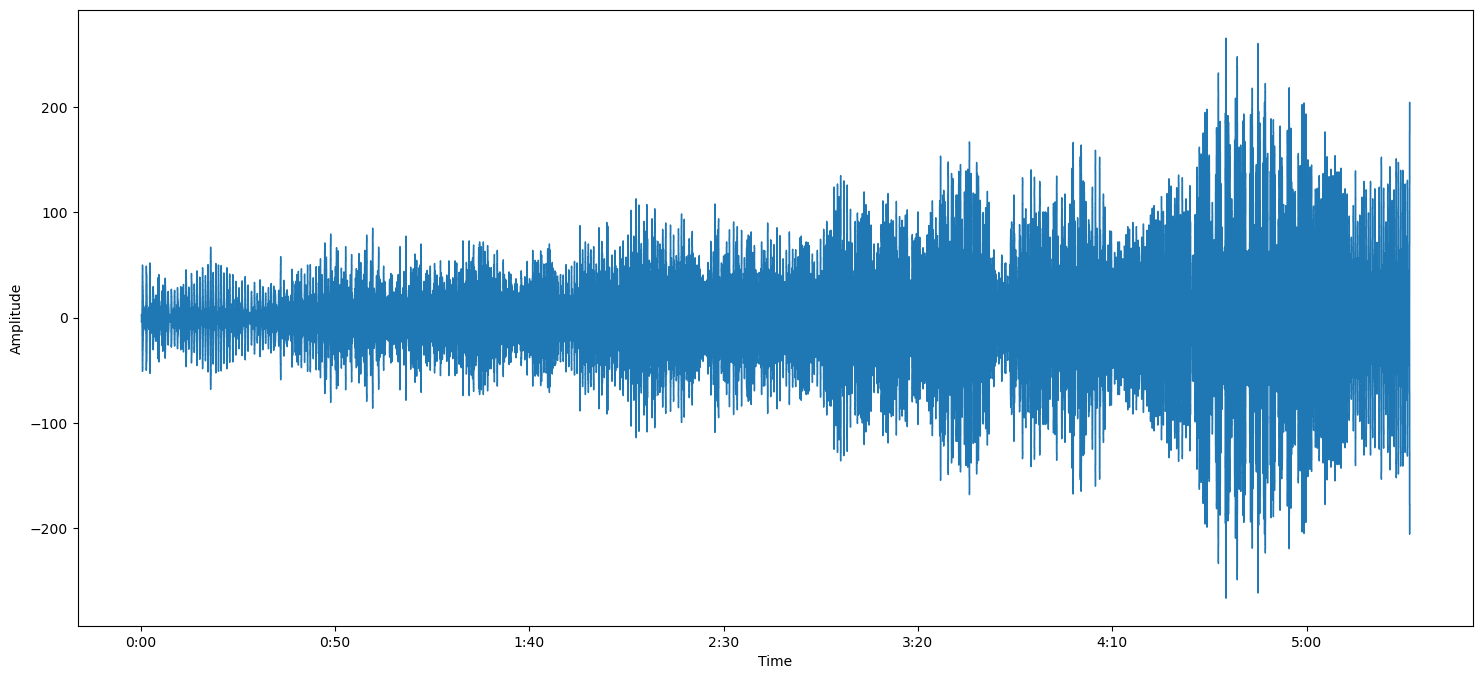

In [20]:
from librosa import display
plt.figure(figsize=(18,8))
display.waveshow(y=ppg,sr=fs)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('')
plt.show()

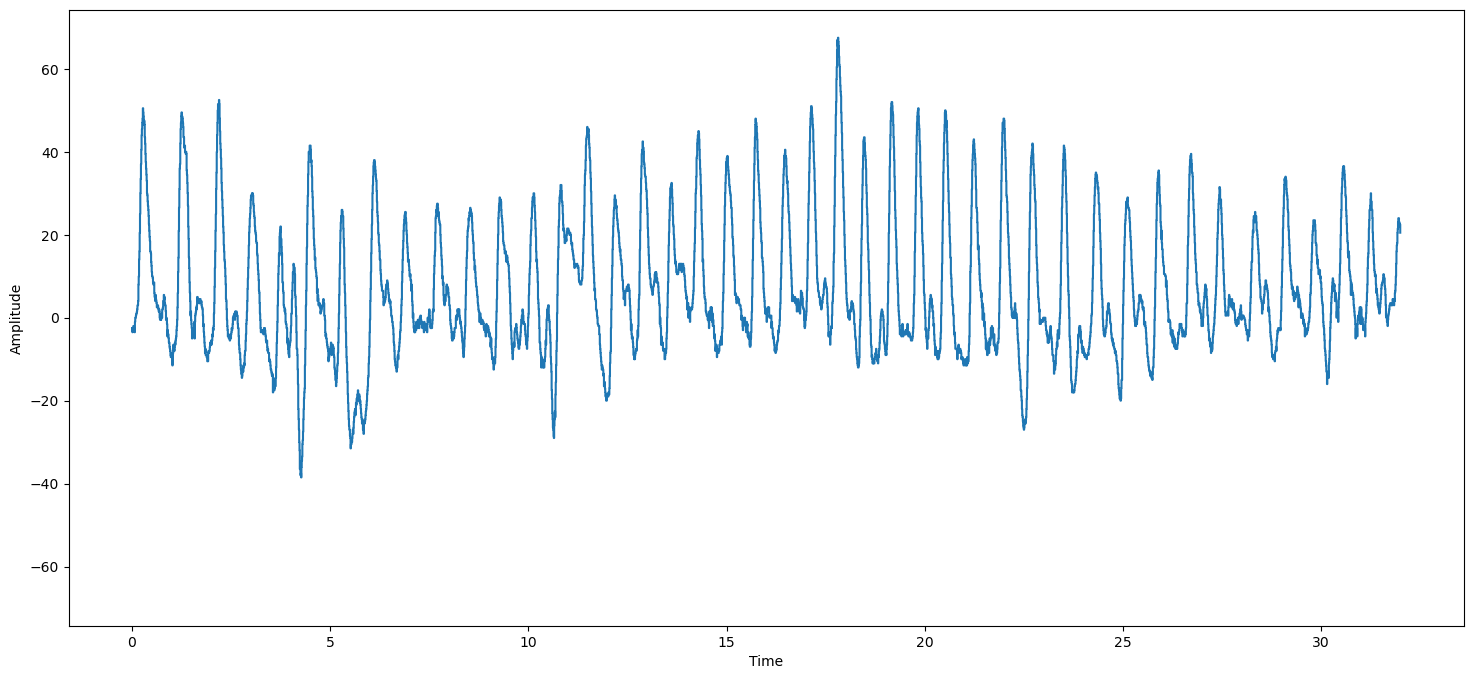

In [21]:
from librosa import display
plt.figure(figsize=(18,8))
display.waveshow(y=ppg[:4000],sr=fs)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('')
plt.show()

In [48]:
len(ppg)/(5*60)

122.16666666666667

In [23]:
import numpy as np
signal = np.array([-2, 8, 6, 4, 1, 0, 3, 5], dtype=float)
fourier = np.fft.fft(signal)
n = signal.size
timestep = 0.1
freq = np.fft.fftfreq(n, d=timestep)
freq, fourier, n

(array([ 0.  ,  1.25,  2.5 ,  3.75, -5.  , -3.75, -2.5 , -1.25]),
 array([ 25.        +0.j        ,   3.36396103-7.94974747j,
        -10.        +1.j        ,  -9.36396103-1.94974747j,
         -9.        +0.j        ,  -9.36396103+1.94974747j,
        -10.        -1.j        ,   3.36396103+7.94974747j]),
 8)

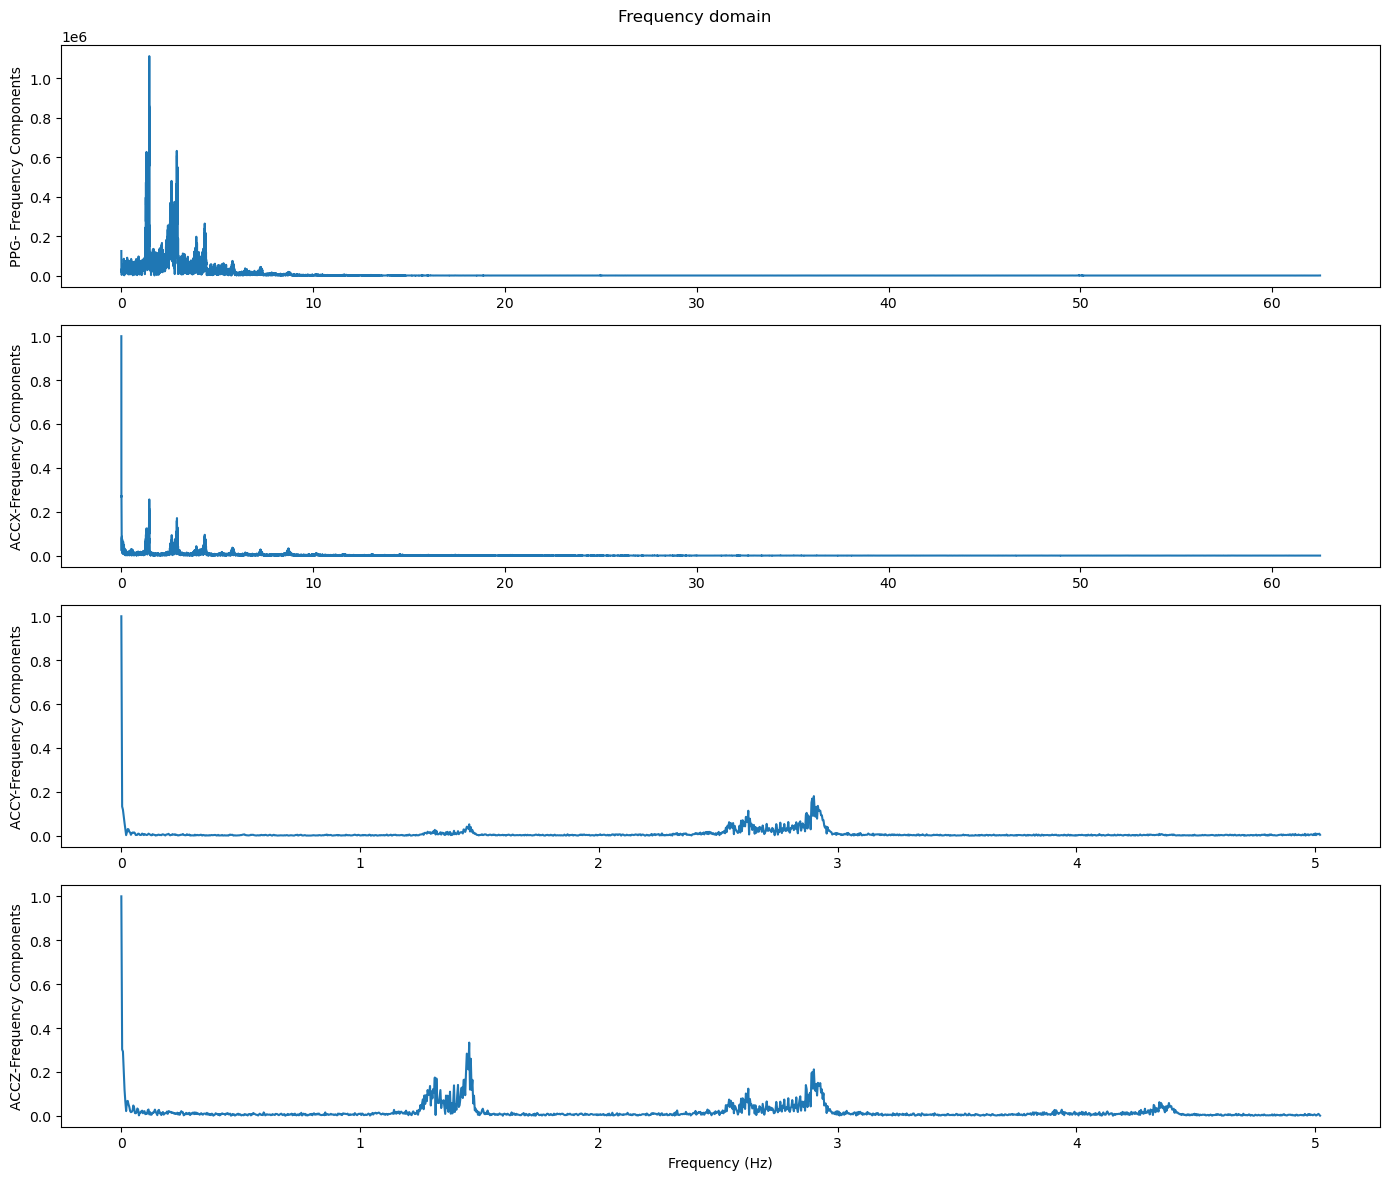

In [55]:
idx=11
print_arr_len=1500
ppg,accx,accy,accz,ref=get_sensor_signals(data,idx)
fft_results=[]
fft_ppg = np.abs(np.fft.rfft(ppg))
freq_ppg = np.fft.rfftfreq(len(ppg), 1/fs)

fft_accx = np.abs(np.fft.rfft(accx))
freq_accx = np.fft.rfftfreq(len(accx), 1/fs)
        
fft_accy = np.abs(np.fft.rfft(accy))
freq_accy = np.fft.rfftfreq(len(accy), 1/fs)
        
fft_accz = np.abs(np.fft.rfft(accz))
freq_accz = np.fft.rfftfreq(len(accz), 1/fs)


fig, axs = plt.subplots(4, 1,figsize=(14,12))
axs[0].plot(freq_ppg[:],fft_ppg[:])
#axs[0].set_xlabel('Frequency (Hz)')
axs[0].set_ylabel('PPG- Frequency Components')

axs[1].plot(freq_accx[:],fft_accx[:]/max(fft_accx))
#axs[1].set_xlabel('Frequency (Hz)')
axs[1].set_ylabel('ACCX-Frequency Components')

axs[2].plot(freq_accy[:1500],fft_accy[:1500]/max(fft_accy))
#axs[2].set_xlabel('Frequency (Hz)')
axs[2].set_ylabel('ACCY-Frequency Components')

axs[3].plot(freq_accz[:1500],fft_accz[:1500]/max(fft_accz))
axs[3].set_xlabel('Frequency (Hz)')
axs[3].set_ylabel('ACCZ-Frequency Components')

plt.suptitle('Frequency domain')
fig.tight_layout()



In [25]:
len(fft_ppg), len(freq_ppg)

(18659, 18659)

In [26]:
freq_ppg[:15],fft_ppg[:15]

(array([0.        , 0.00334977, 0.00669954, 0.01004931, 0.01339908,
        0.01674885, 0.02009862, 0.02344839, 0.02679816, 0.03014793,
        0.0334977 , 0.03684746, 0.04019723, 0.043547  , 0.04689677]),
 array([124227.        ,  18464.77129534,  19106.7780504 ,  28993.72133732,
         30172.63408839,  20089.68040579,   3156.62213015,  16851.0979835 ,
         31936.11770068,  36780.15431518,  34346.55362934,  10671.40690959,
         32152.74323337,  47122.91124323,  36563.61803483]))

(37328, 37328, 37328, 37328)


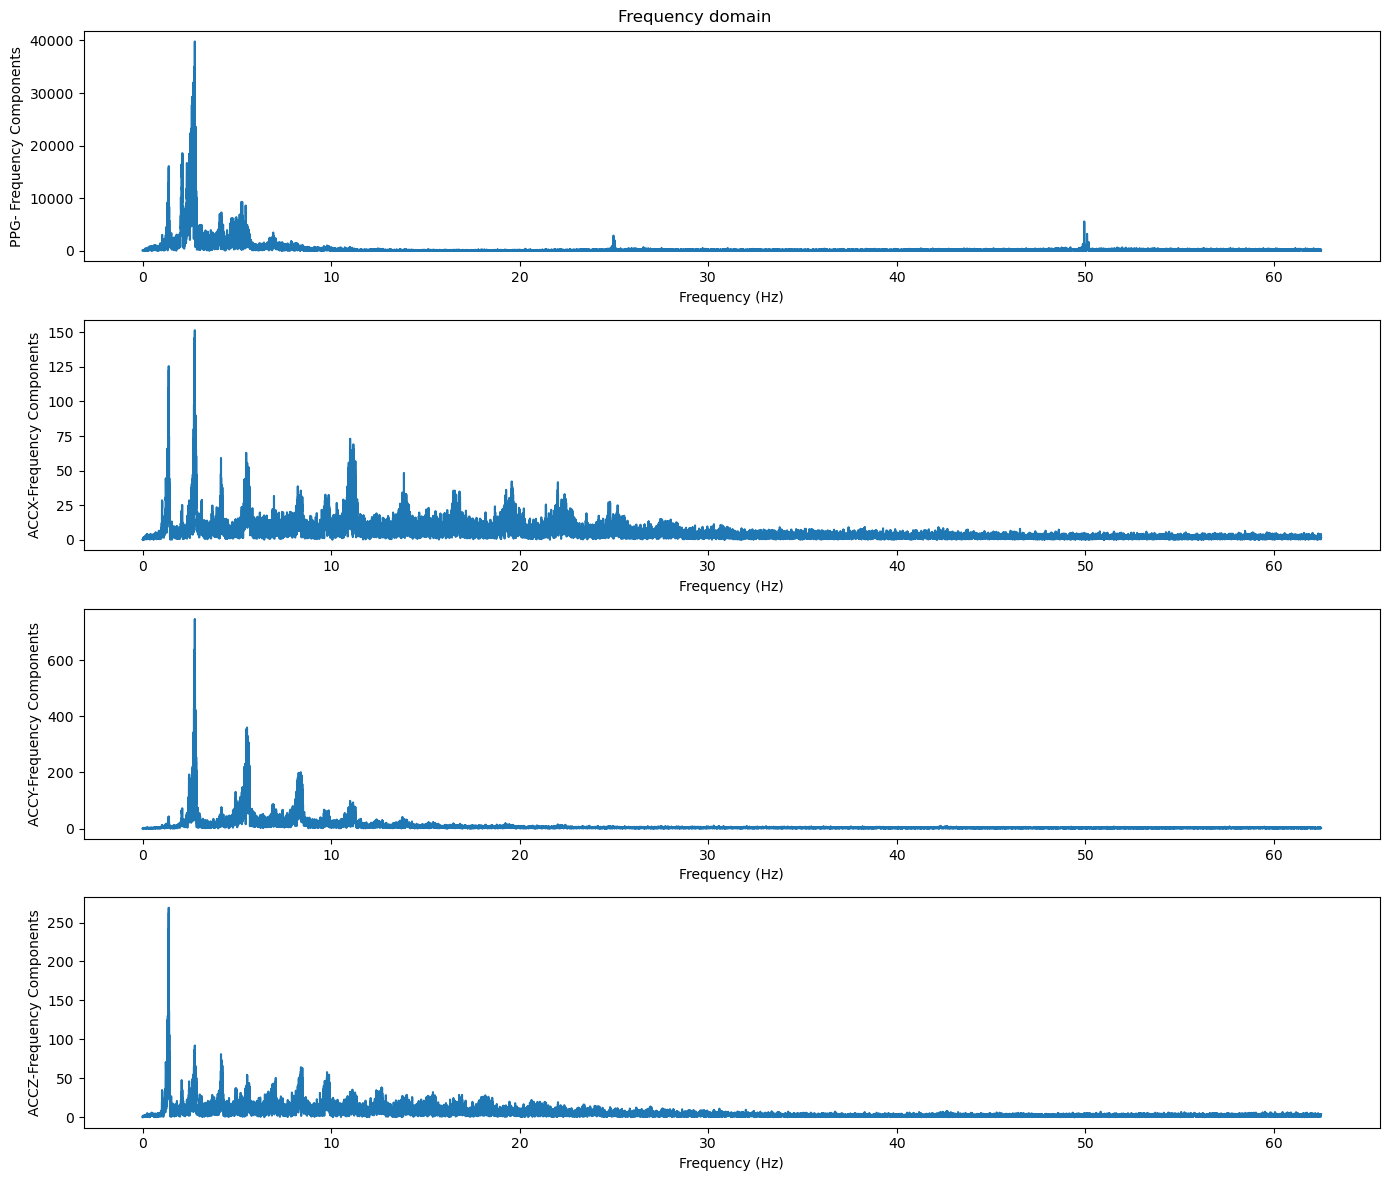

In [30]:
idx=5
print(shapes[idx][:4])

ppg=np.diff(df_data[idx].iloc[:,2])
fft_ppg = np.abs(np.fft.rfft(ppg))
freq_ppg = np.fft.rfftfreq(len(ppg), 1/fs)

accx=np.diff(df_data[idx].iloc[:,3])
fft_accx = np.abs(np.fft.rfft(accx))
freq_accx = np.fft.rfftfreq(len(accx), 1/fs)
        

accy=np.diff(df_data[idx].iloc[:,4])
fft_accy = np.abs(np.fft.rfft(accy))
freq_accy = np.fft.rfftfreq(len(accy), 1/fs)
        

accz=np.diff(df_data[idx].iloc[:,5])
fft_accz = np.abs(np.fft.rfft(accz))
freq_accz = np.fft.rfftfreq(len(accz), 1/fs)
        

fig, axs = plt.subplots(4, 1,figsize=(14,12))
axs[0].plot(freq_ppg,fft_ppg)
axs[0].set_xlabel('Frequency (Hz)')
axs[0].set_ylabel('PPG- Frequency Components')

axs[1].plot(freq_accx,fft_accx)
axs[1].set_xlabel('Frequency (Hz)')
axs[1].set_ylabel('ACCX-Frequency Components')

axs[2].plot(freq_accy,fft_accy)
axs[2].set_xlabel('Frequency (Hz)')
axs[2].set_ylabel('ACCY-Frequency Components')

axs[3].plot(freq_accz,fft_accz)
axs[3].set_xlabel('Frequency (Hz)')
axs[3].set_ylabel('ACCZ-Frequency Components')

plt.suptitle('Frequency domain')
fig.tight_layout()

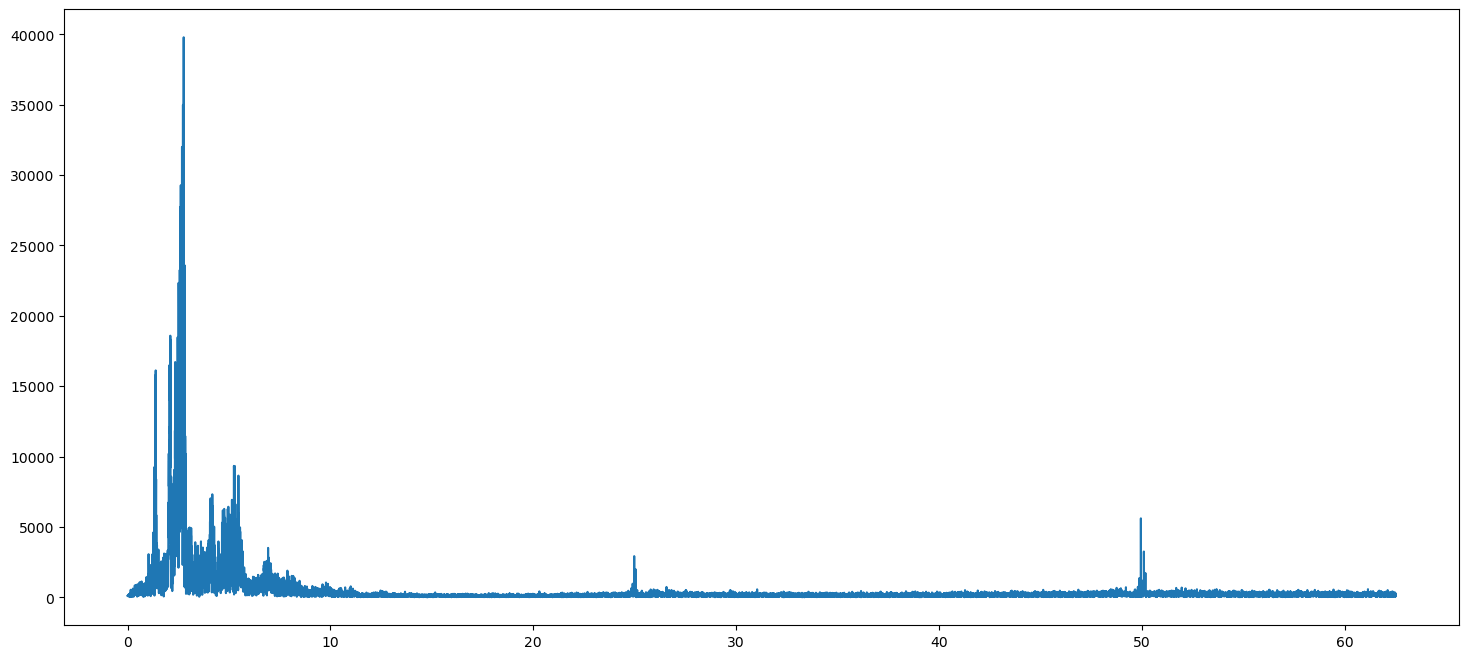

In [31]:
import scipy
n=len(ppg)
T=1/fs
yf=np.abs(scipy.fft.rfft(ppg))
freqs = scipy.fft.fftshift(scipy.fft.rfftfreq(n, T))
xf=np.linspace(0.0,1.0/(2.0*T),(n//2)+1)
plt.figure(figsize=(18,8))
plt.plot(xf,yf)
plt.show()

In [33]:
def dft_shift(X):
    N = len(X)
    if (N % 2 == 0):
        # even-length: return N+1 values
        return np.arange(-int(N/2), int(N/2) + 1), np.concatenate((X[int(N/2):], X[:int(N/2)+1]))
    else:
        # odd-length: return N values
        return np.arange(-int((N-1)/2), int((N-1)/2) + 1), np.concatenate((X[int((N+1)/2):], X[:int((N+1)/2)]))
    
def dft_map(X, Fs, shift=True):
    resolution = float(Fs) / len(X)
    if shift:
        n, Y = dft_shift(X)
    else:
        Y = X
        n = np.arange(0, len(Y))
    f = n * resolution
    return f, Y

In [37]:
N=len(X)
X[int(N/2):]

array([  755.5       +734.j        ,   537.62255765-734.88179573j,
         274.58617372+572.36053417j, ...,  -627.63828258-381.47245669j,
       -1214.39208765-345.36494167j,  -492.5         +0.j        ])

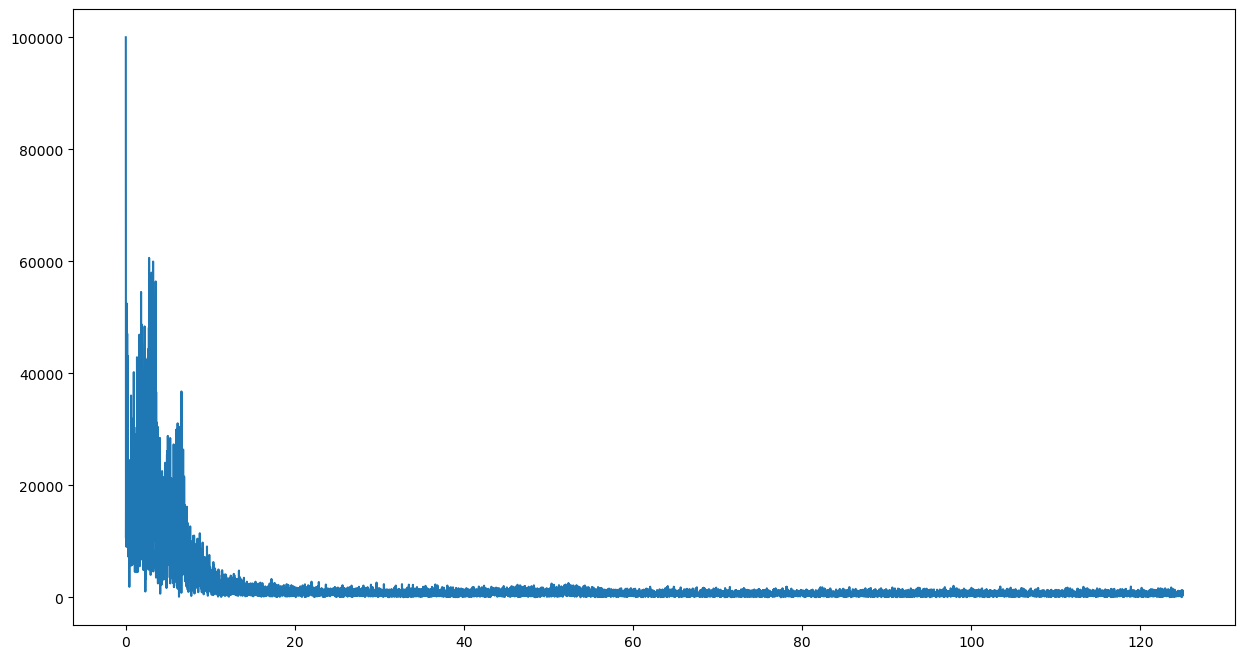

In [39]:
idx=3
ppg,accx,accy,accz,ref=get_sensor_signals(data,idx)
X = np.fft.rfft(ppg);
f,y=dft_map(X,fs,shift=False)
plt.figure(figsize=(15,8))
plt.plot(f,np.abs(y))

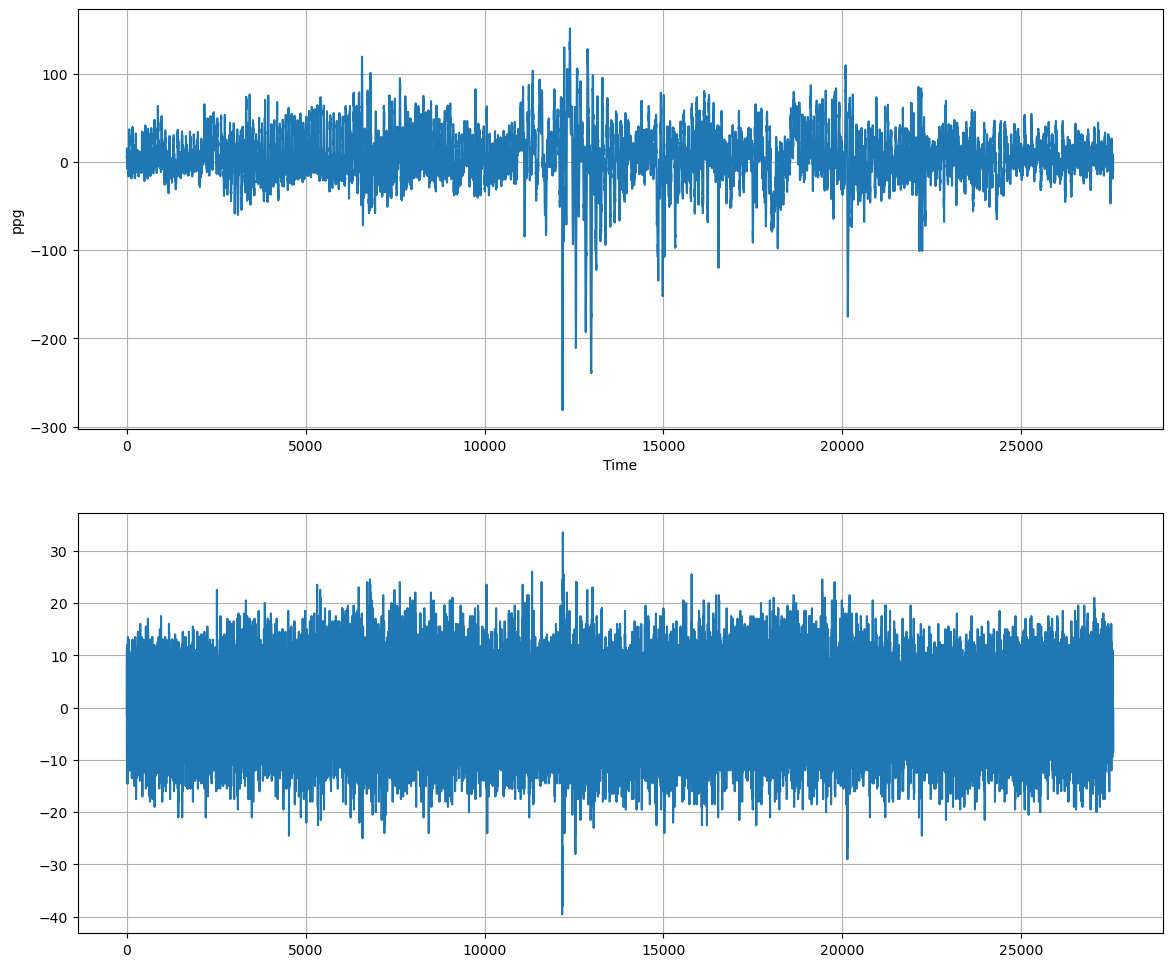

In [43]:
diff=np.diff(ppg)
ts=np.arange(0,len(ppg))
fig, axs = plt.subplots(2, 1,figsize=(14,12))

axs[0].plot(ts,ppg)
axs[0].set_xlabel('Time')
axs[0].set_ylabel('ppg')
# axs[0].vlines(x=speed_change_time_in_fs, ymin=ppg.min(),ymax=ppg.max(),colors='purple', ls='-.', lw=1)
axs[0].grid(True)


axs[1].plot(ts[:-1],diff)
axs[1].grid(True)


In [176]:
b, a = sps.butter(3, (40/60, 240/60), btype='bandpass', fs=fs)
b,a

(array([ 0.00050068,  0.        , -0.00150203,  0.        ,  0.00150203,
         0.        , -0.00050068]),
 array([  1.        ,  -5.64616077,  13.30790845, -16.76128548,
         11.89848409,  -4.51392797,   0.71498194]))

In [49]:
np.sort(fft_accx)[-10:]

array([ 89.97837755,  93.33298999,  97.75455826, 109.60679662,
       114.4331477 , 122.61053829, 125.49897251, 131.0548061 ,
       146.0415546 , 151.43977386])

In [50]:
np.sort(fft_ppg)[-10:]

array([29092.60721544, 29274.33706893, 30088.94019258, 31539.2531277 ,
       31581.51994   , 31982.63469215, 32043.62069975, 33243.94350969,
       34985.98448064, 39786.92961991])

In [56]:
fs

125

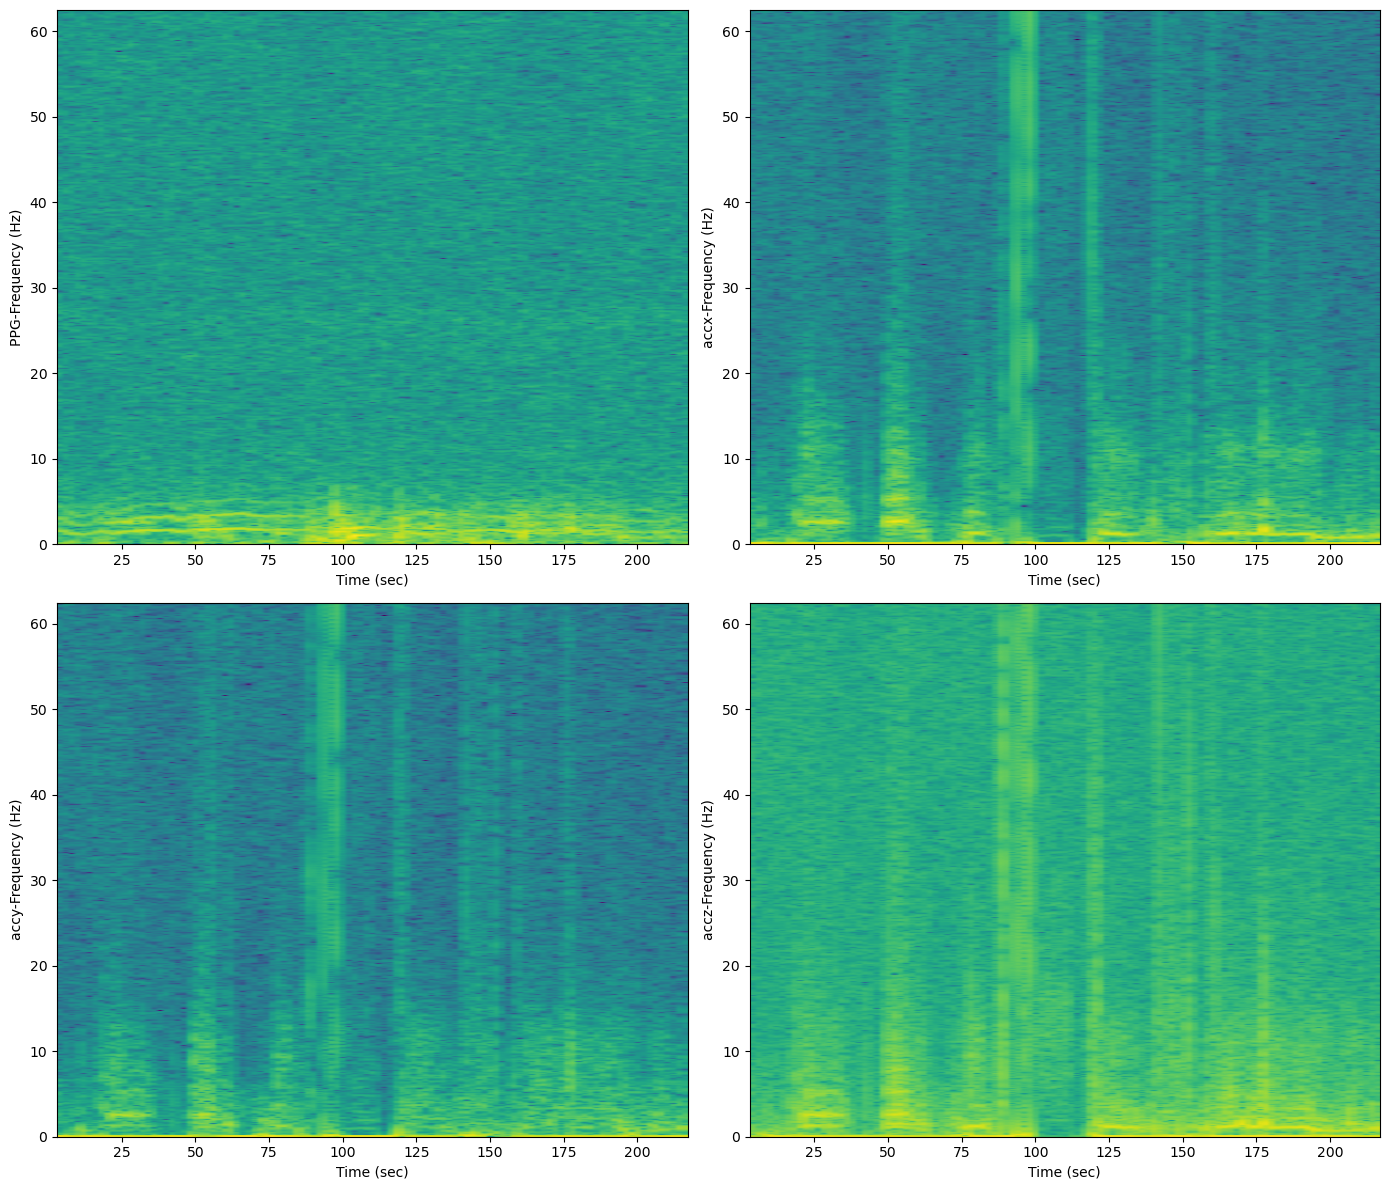

In [57]:
idx=3
ppg,accx,accy,accz,ref=get_sensor_signals(data,idx)
NFFT=fs*8
noverlap=fs*6

fig, axs = plt.subplots(2, 2,figsize=(14,12))

#plt.title('Spectrogram')
axs[0,0].specgram(ppg, Fs=fs, NFFT=NFFT, noverlap=noverlap)
# plt.ylim((0, 20))
axs[0,0].set_xlabel('Time (sec)')
axs[0,0].set_ylabel('PPG-Frequency (Hz)')

axs[0,1].specgram(accx, Fs=fs, NFFT=NFFT, noverlap=noverlap)
# plt.ylim((0, 20))
axs[0,1].set_xlabel('Time (sec)')
axs[0,1].set_ylabel('accx-Frequency (Hz)')

axs[1,0].specgram(accy, Fs=fs, NFFT=NFFT, noverlap=noverlap)
# plt.ylim((0, 20))
axs[1,0].set_xlabel('Time (sec)')
axs[1,0].set_ylabel('accy-Frequency (Hz)')

axs[1,1].specgram(accz, Fs=fs, NFFT=NFFT, noverlap=noverlap)
# plt.ylim((0, 20))
axs[1,1].set_xlabel('Time (sec)')
axs[1,1].set_ylabel('accz-Frequency (Hz)')

fig.tight_layout()

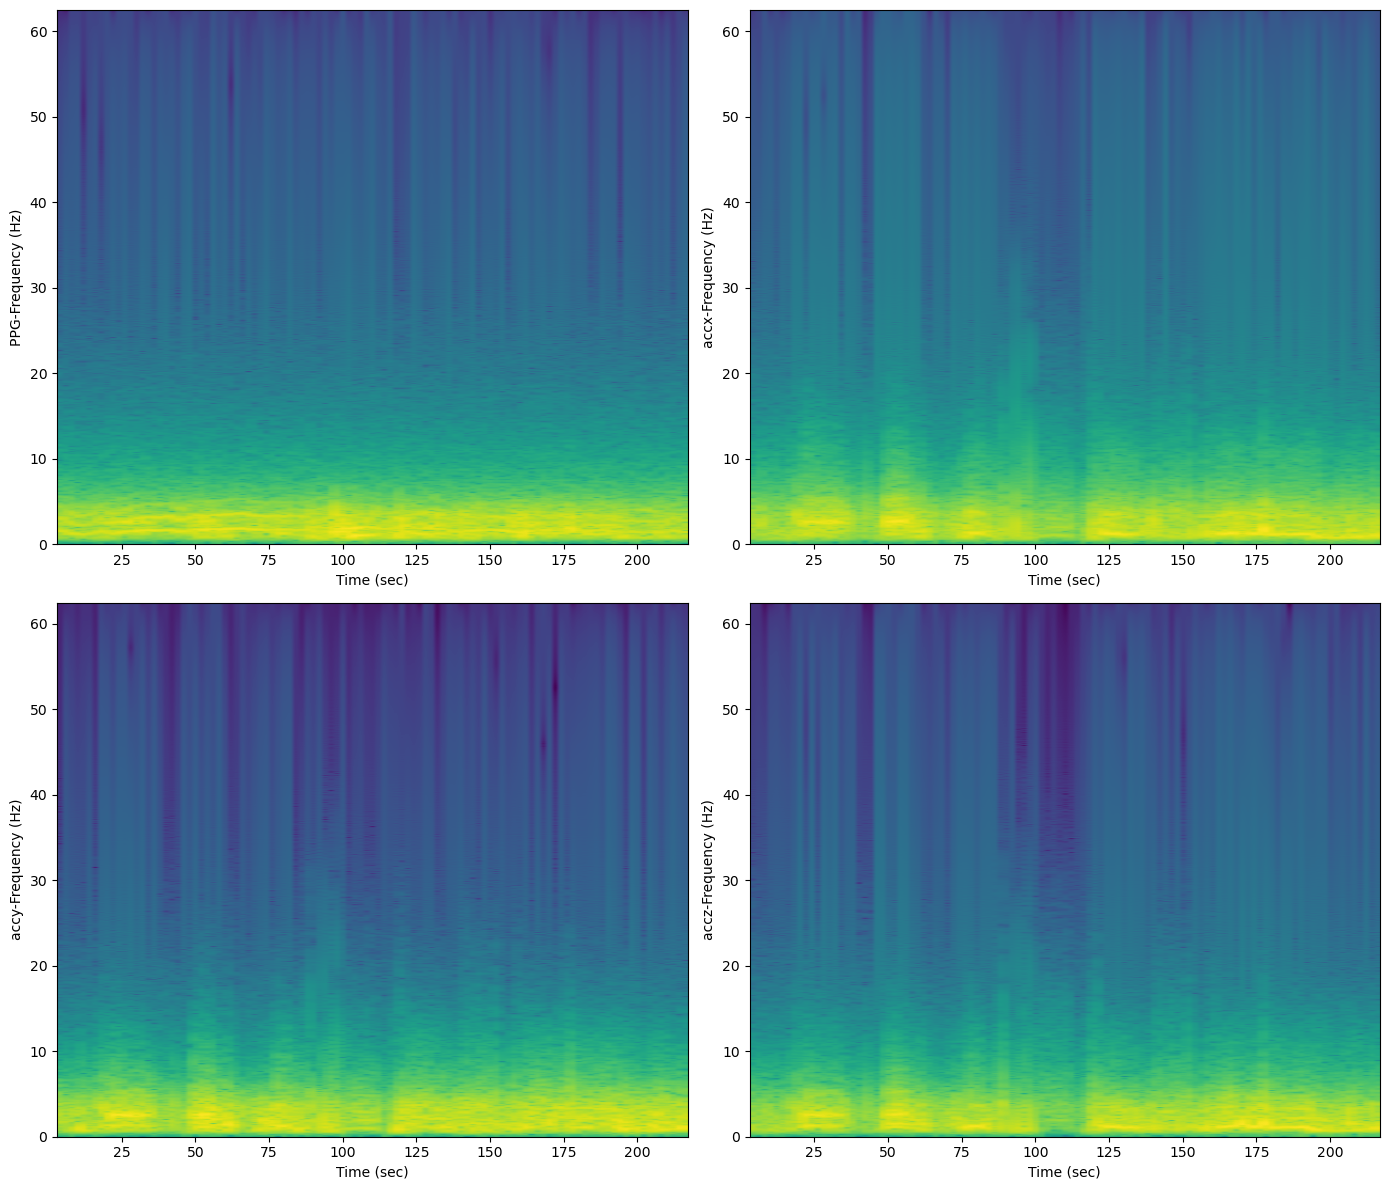

<Figure size 640x480 with 0 Axes>

In [58]:
#Load PPG and Accelerometer Signals.  Get Freqs and FFT Spectra for PPG and Accelerometer signals.
fig, axs = plt.subplots(2, 2,figsize=(14,12))


fs=125
nfft_window = fs*8
noverlap = fs*6
plt.figure()
filtered_ppg = BandpassFilter(ppg)
filtered_accx = BandpassFilter(accx)
filtered_accy = BandpassFilter(accy)
filtered_accz = BandpassFilter(accz)

#plt.title('Spectrogram')
filt_ppg_specs, filt_ppg_freqs,_,filt_ppg_im = axs[0,0].specgram(filtered_ppg, Fs=fs, NFFT=nfft_window, noverlap=noverlap)
# plt.ylim((0, 20))
axs[0,0].set_xlabel('Time (sec)')
axs[0,0].set_ylabel('PPG-Frequency (Hz)')

accx_specs, accx_freqs,_,_ = axs[0,1].specgram(filtered_accx, Fs=fs, NFFT=nfft_window, noverlap=noverlap)
# plt.ylim((0, 20))
axs[0,1].set_xlabel('Time (sec)')
axs[0,1].set_ylabel('accx-Frequency (Hz)')

accy_specs, accy_freqs,_,_ = axs[1,0].specgram(filtered_accy, Fs=fs, NFFT=nfft_window, noverlap=noverlap)
# plt.ylim((0, 20))
axs[1,0].set_xlabel('Time (sec)')
axs[1,0].set_ylabel('accy-Frequency (Hz)')

accz_specs, accz_freqs,_,_ = axs[1,1].specgram(filtered_accz, Fs=fs, NFFT=nfft_window, noverlap=noverlap)
# plt.ylim((0, 20))
axs[1,1].set_xlabel('Time (sec)')
axs[1,1].set_ylabel('accz-Frequency (Hz)')

fig.tight_layout()


In [60]:
filt_ppg_specs.shape

(501, 107)

In [63]:
 filt_ppg_freqs.shape

(501,)

In [65]:
len(data)

12

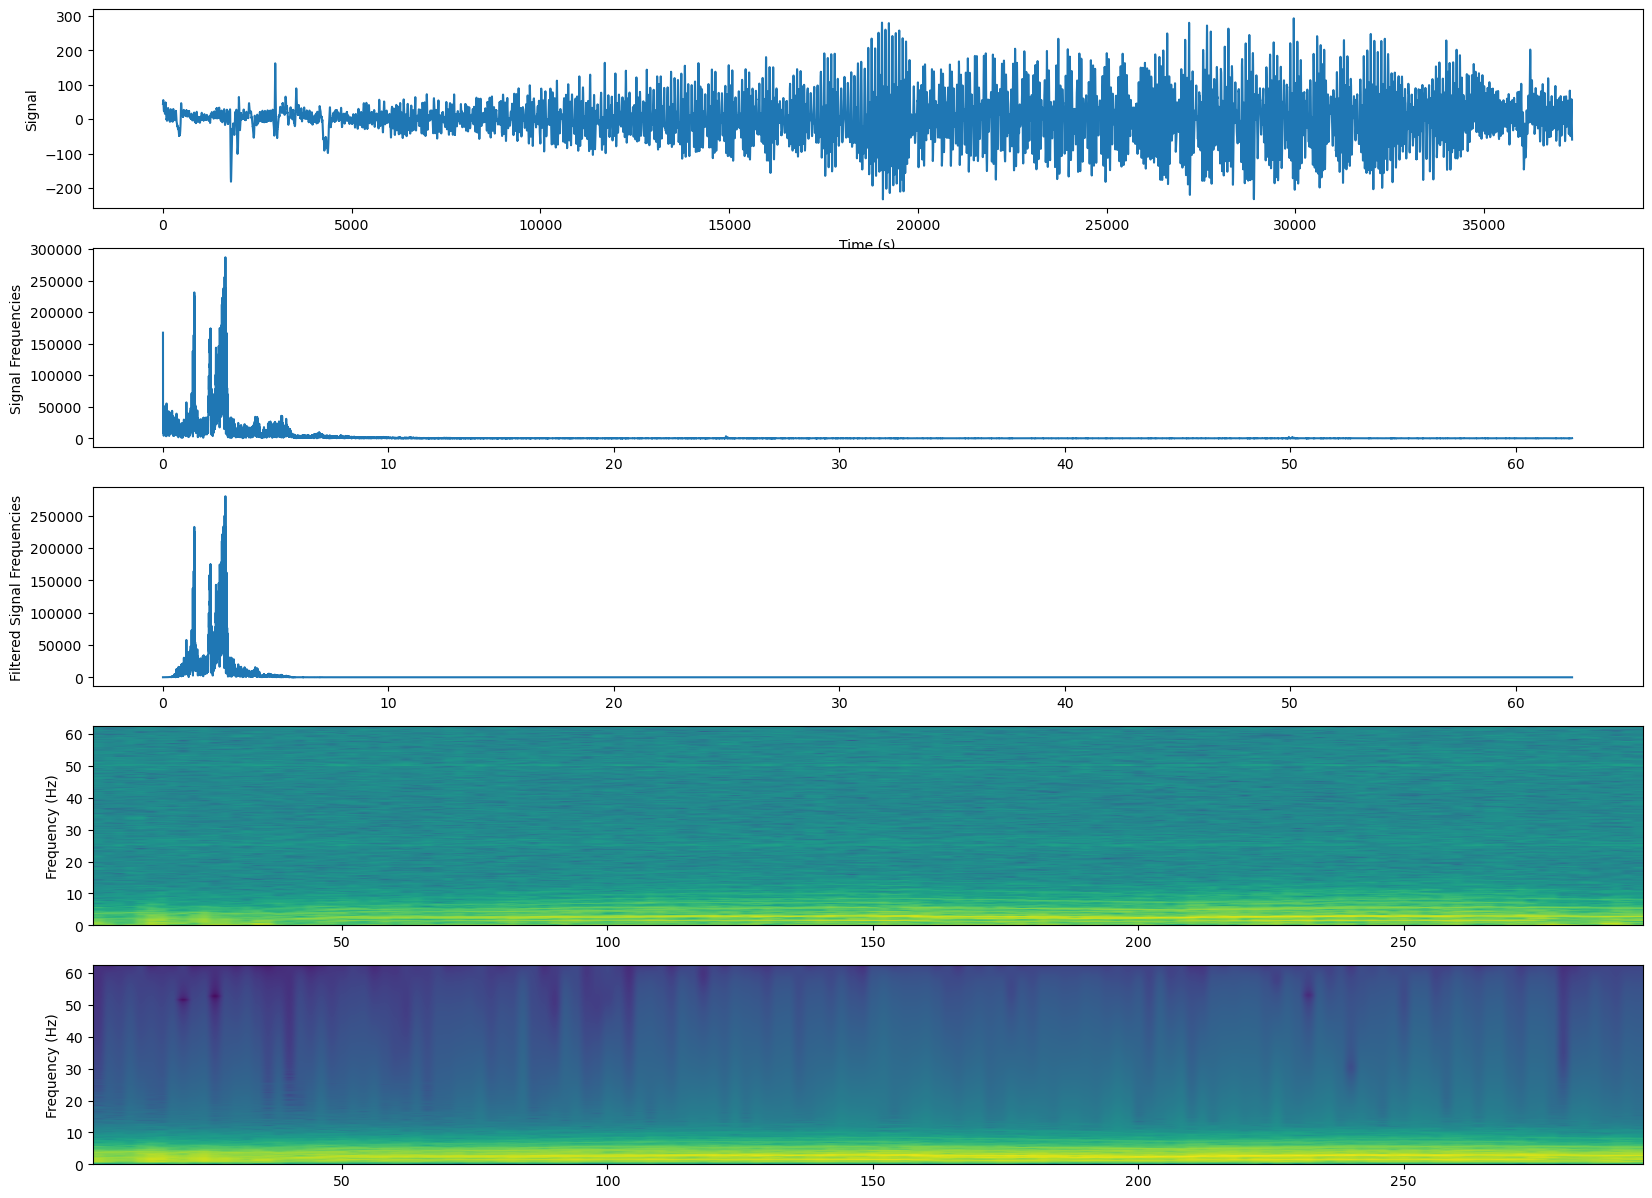

In [83]:
idx=5 #choose from 0-12
fs=125
nfft_window = fs*8
noverlap = fs*6
ppg,accx,accy,accz,ref=get_sensor_signals(data, idx)

signal=ppg
ts=np.arange(0,len(signal))

filtered_signal = BandpassFilter(signal)
fft_signal = np.abs(np.fft.rfft(signal))
freq_signal = np.fft.rfftfreq(len(signal), 1/fs)

fft_filtered_signal = np.abs(np.fft.rfft(filtered_signal))
# freq_filtered_ppg = np.fft.rfftfreq(len(filtered_signal), 1/fs)

fig, axs = plt.subplots(figsize=(20,15), nrows=5, ncols=1, sharex=False)
axs[0].plot(ts, signal)
axs[0].set_ylabel('Signal')

axs[1].plot(freq_signal, fft_signal)
axs[1].set_ylabel('Signal Frequencies')

axs[2].plot(freq_signal, fft_filtered_signal)
axs[2].set_ylabel('Filtered Signal Frequencies')

Pxx, freqs, bins, im = axs[3].specgram(signal, NFFT=nfft_window, Fs=fs, noverlap=noverlap)
# axs[2,0].plot(ts,filtered_ppg)
axs[3].set_ylabel('Frequency (Hz)')

Pxx, freqs, bins, im = axs[4].specgram(filtered_signal, NFFT=nfft_window, Fs=fs, noverlap=noverlap)
# The `specgram` method returns 4 objects. They are:
# - Pxx: the periodogram
# - freqs: the frequency vector
# - bins: the centers of the time bins
# - im: the .image.AxesImage instance representing the data in the plot

axs[0].set_xlabel('Time (s)')
axs[4].set_ylabel('Frequency (Hz)')
# ax2.set_xlim(0, 20)

plt.show()

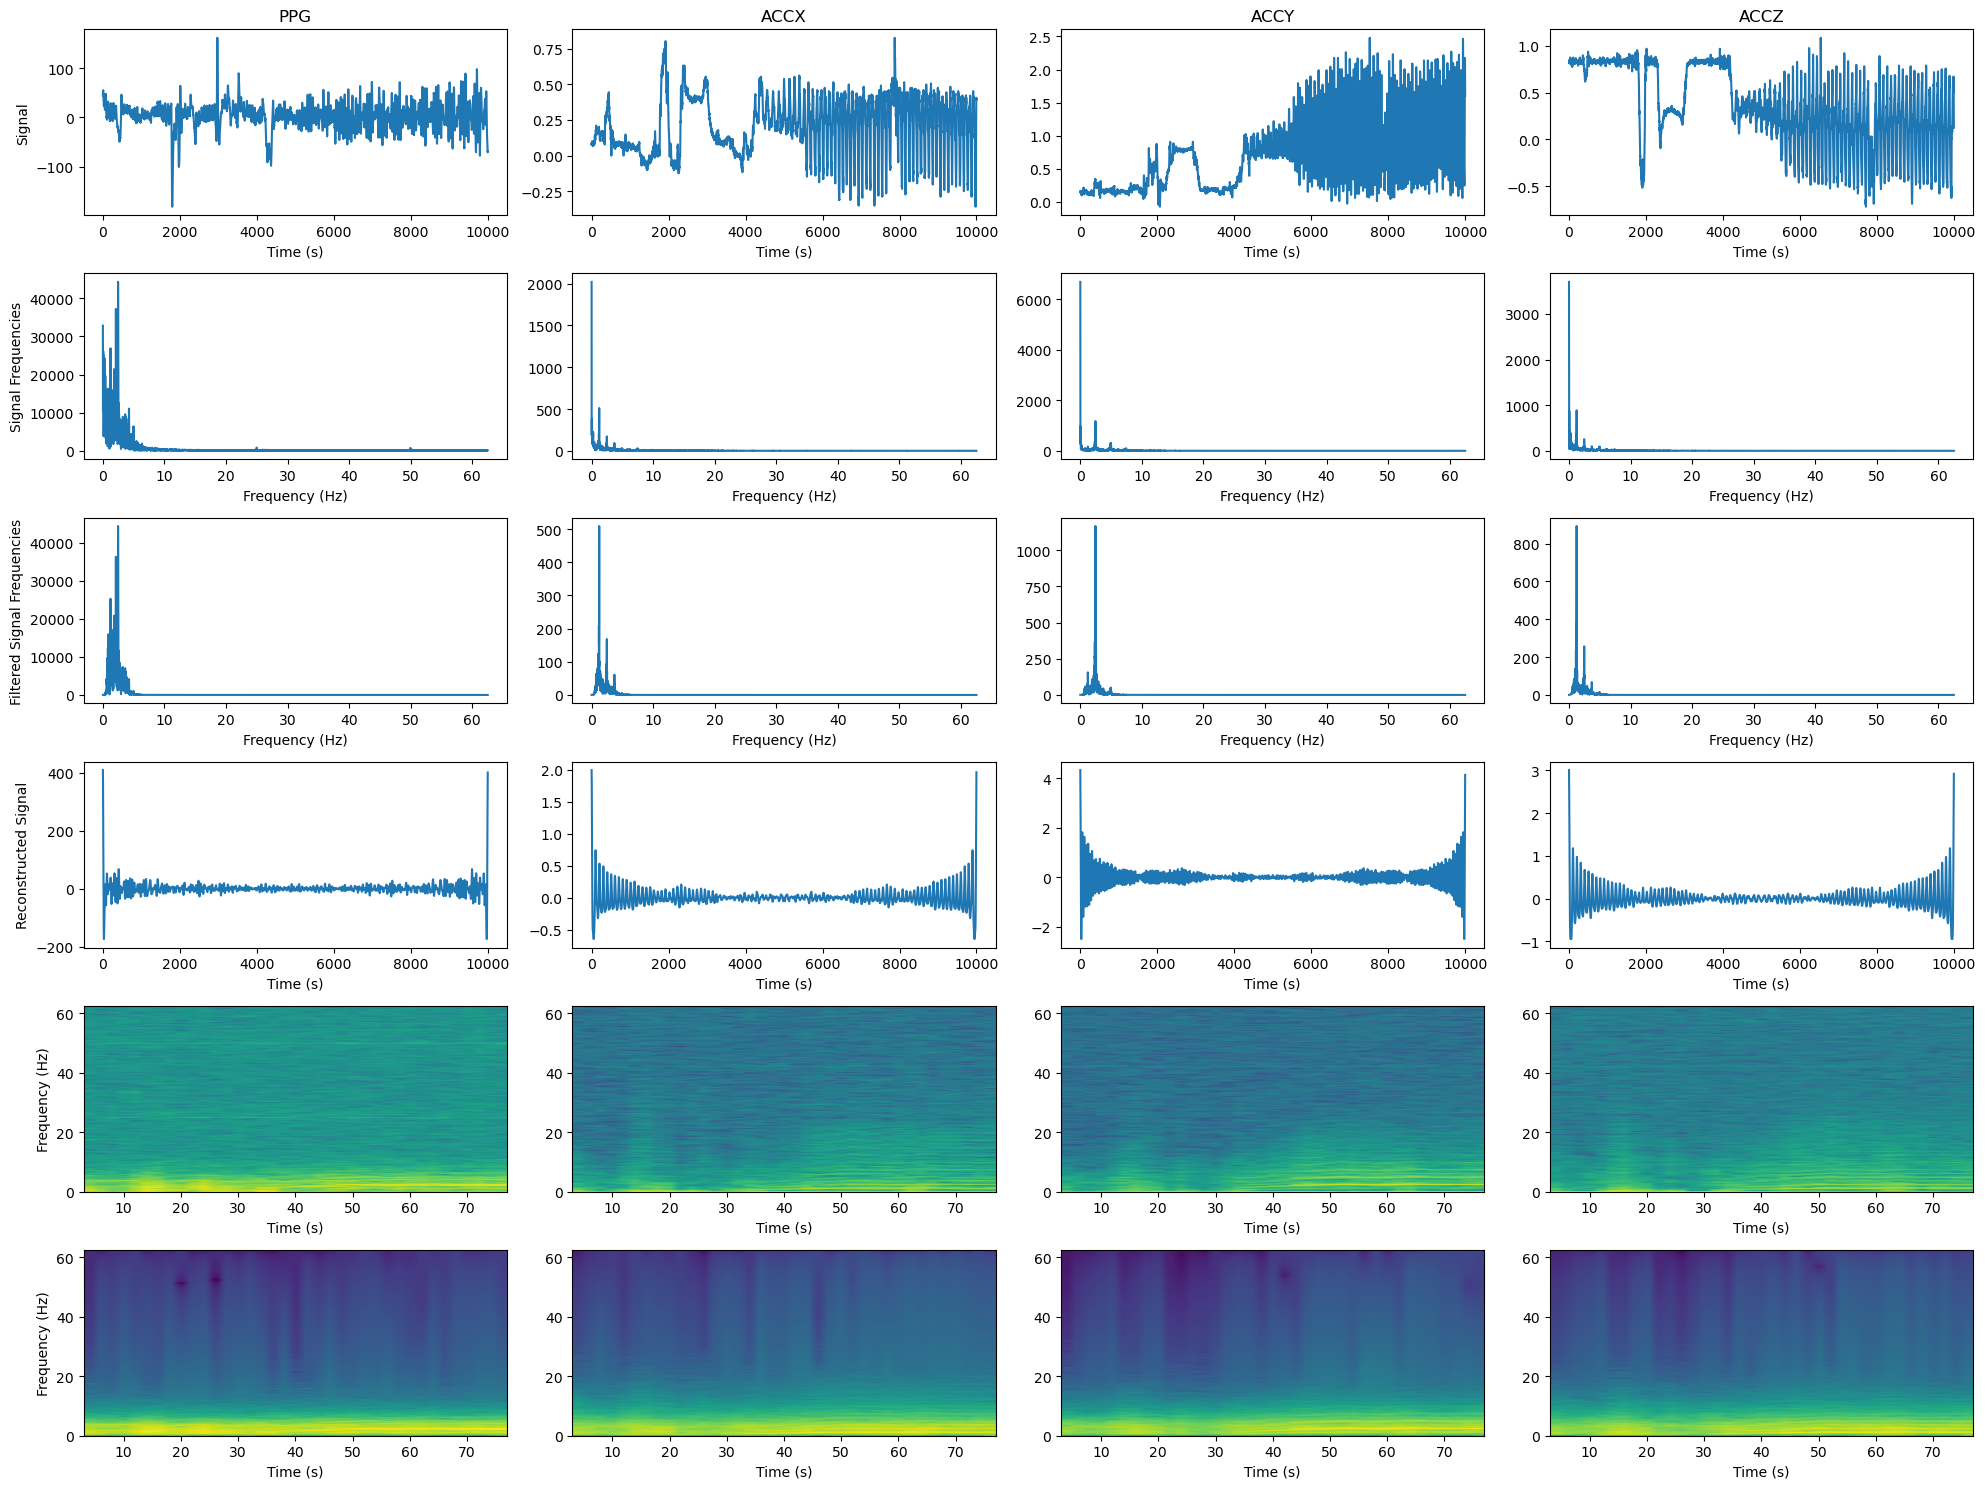

In [109]:
idx=5 #choose from 0-12
fs=125
nfft_window = fs*8
noverlap = fs*6
ppg,accx,accy,accz,ref=get_sensor_signals(data, idx)


def plot_signal_spectrum(signal, col_num, show_arr_len=None, title=None):
    if show_arr_len:
        signal=signal[:show_arr_len]
    ts=np.arange(0,len(signal))
    filtered_signal = BandpassFilter(signal)

    fft_signal = np.abs(np.fft.rfft(signal))
    freq_signal = np.fft.rfftfreq(len(signal), 1/fs)
    
    fft_filtered_signal = np.abs(np.fft.rfft(filtered_signal))

    new_signal=np.fft.irfft(fft_filtered_signal)
                      
    axs[0,col_num].plot(ts, signal)
    axs[0,0].set_ylabel('Signal')
    axs[0,col_num].title.set_text(title)
    
    axs[1,col_num].plot(freq_signal, fft_signal)
    axs[1,0].set_ylabel('Signal Frequencies')
    
    axs[2,col_num].plot(freq_signal, fft_filtered_signal)
    axs[2,0].set_ylabel('Filtered Signal Frequencies')
    
    axs[3,col_num].plot(new_signal)
    axs[3,0].set_ylabel('Reconstructed Signal')

    Pxx, freqs, bins, im = axs[4,col_num].specgram(signal, NFFT=nfft_window, Fs=fs, noverlap=noverlap)
    # The `specgram` method returns 4 objects. They are:
    # - Pxx: the periodogram
    # - freqs: the frequency vector
    # - bins: the centers of the time bins
    # - im: the .image.AxesImage instance representing the data in the plot

                      
    Pxx, freqs, bins, im = axs[5,col_num].specgram(filtered_signal, NFFT=nfft_window, Fs=fs, noverlap=noverlap)
    # set x labels
    axs[0,col_num].set_xlabel('Time (s)')
    axs[1,col_num].set_xlabel('Frequency (Hz)')
    axs[2,col_num].set_xlabel('Frequency (Hz)')
    axs[3,col_num].set_xlabel('Time (s)')
    axs[4,col_num].set_xlabel('Time (s)')
    axs[5,col_num].set_xlabel('Time (s)')
    
    #set y labels
    axs[4,0].set_ylabel('Frequency (Hz)')
    axs[5,0].set_ylabel('Frequency (Hz)')

    return None


show_arr_len=len(ppg)
show_arr_len=10000

fig, axs = plt.subplots(figsize=(20,15), nrows=6, ncols=4, sharex=False, sharey=False)
plot_signal_spectrum(signal=ppg, col_num=0, show_arr_len=show_arr_len, title='PPG')
plot_signal_spectrum(signal=accx, col_num=1, show_arr_len=show_arr_len, title='ACCX')
plot_signal_spectrum(signal=accy, col_num=2, show_arr_len=show_arr_len, title='ACCY')
plot_signal_spectrum(signal=accz, col_num=3, show_arr_len=show_arr_len, title='ACCZ')

plt.tight_layout()
plt.show()

In [ ]:
ppg_max_freqs = []
distance_bpm = 10 # Hyperparameter that was tested from 5 BPM to 20 BPM
distance_bps = distance_bpm/60 # Conversion 1 Hz = 1 cycles per minute * (1 min/60 s)
count=0
inner=0
for i in range(filt_ppg_specs.shape[1]):
    accx_max_freq = accx_freqs[np.argmax(accx_specs[:,i])]
    accy_max_freq = accy_freqs[np.argmax(accy_specs[:,i])]
    accz_max_freq = accz_freqs[np.argmax(accz_specs[:,i])]
    sorted_ppg_specs = np.sort(filt_ppg_specs[:,i])[::-1]
    count += 1
    #for f in range(filt_ppg_specs.shape[0]):
    for f in range(10):
        ppg_freq = filt_ppg_freqs[np.argwhere(filt_ppg_specs == (sorted_ppg_specs[f]))[0][0]]
        inner+=1
        if ppg_freq == 0:
            continue
        elif (np.abs(ppg_freq-accx_max_freq)<=distance_bps) or (np.abs(ppg_freq-accy_max_freq)<=distance_bps) or (np.abs(ppg_freq-accz_max_freq)<=distance_bps):
            #if f == (filt_ppg_specs.shape[0]-1):
            if f == 9:
                ppg_max_freqs.append(filt_ppg_freqs[np.argwhere(filt_ppg_specs == (sorted_ppg_specs[0]))[0][0]])
            continue
        else:
            ppg_max_freqs.append(ppg_freq)
            break

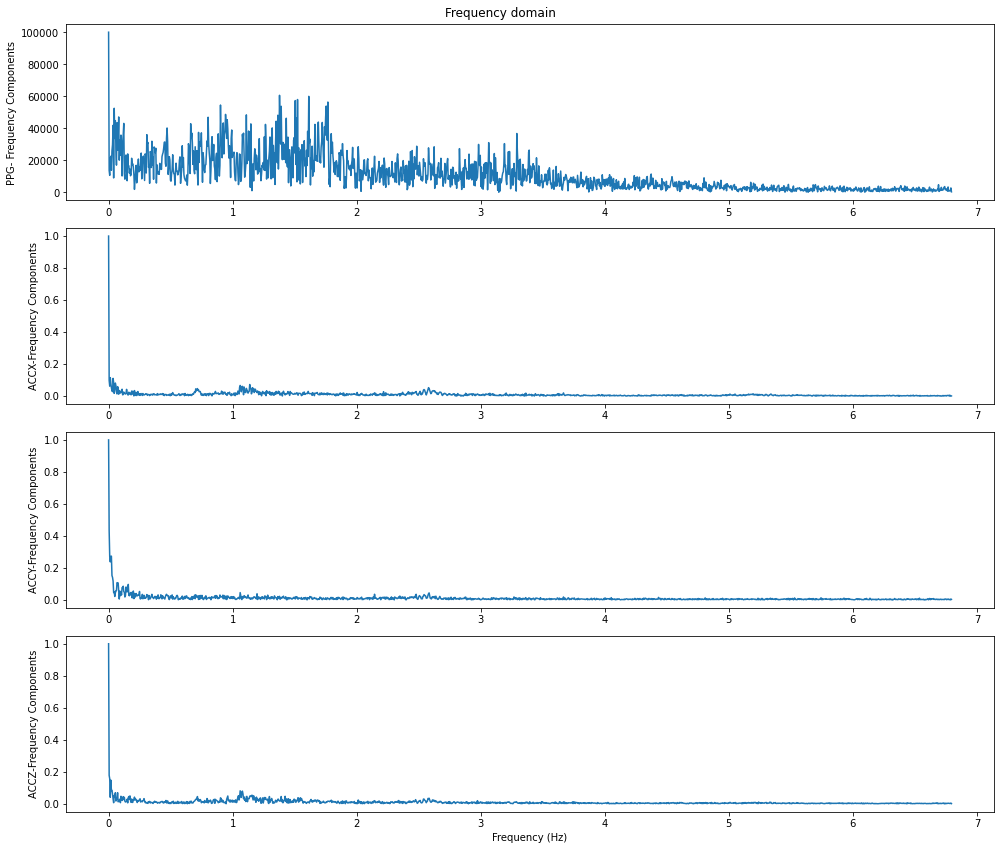

In [100]:
fft_ppg = np.abs(np.fft.rfft(ppg))
freq_ppg = np.fft.rfftfreq(len(ppg), 1/fs)

fft_accx = np.abs(np.fft.rfft(accx))
freq_accx = np.fft.rfftfreq(len(accx), 1/fs)
        
fft_accy = np.abs(np.fft.rfft(accy))
freq_accy = np.fft.rfftfreq(len(accy), 1/fs)
        
fft_accz = np.abs(np.fft.rfft(accz))
freq_accz = np.fft.rfftfreq(len(accz), 1/fs)
        

fig, axs = plt.subplots(4, 1,figsize=(14,12))
axs[0].plot(freq_ppg[:1500],fft_ppg[:1500])
#axs[0].set_xlabel('Frequency (Hz)')
axs[0].set_ylabel('PPG- Frequency Components')

axs[1].plot(freq_accx[:1500],fft_accx[:1500]/max(fft_accx))
#axs[1].set_xlabel('Frequency (Hz)')
axs[1].set_ylabel('ACCX-Frequency Components')

axs[2].plot(freq_accy[:1500],fft_accy[:1500]/max(fft_accy))
#axs[2].set_xlabel('Frequency (Hz)')
axs[2].set_ylabel('ACCY-Frequency Components')

axs[3].plot(freq_accz[:1500],fft_accz[:1500]/max(fft_accz))
axs[3].set_xlabel('Frequency (Hz)')
axs[3].set_ylabel('ACCZ-Frequency Components')

plt.suptitle('Frequency domain')
fig.tight_layout()



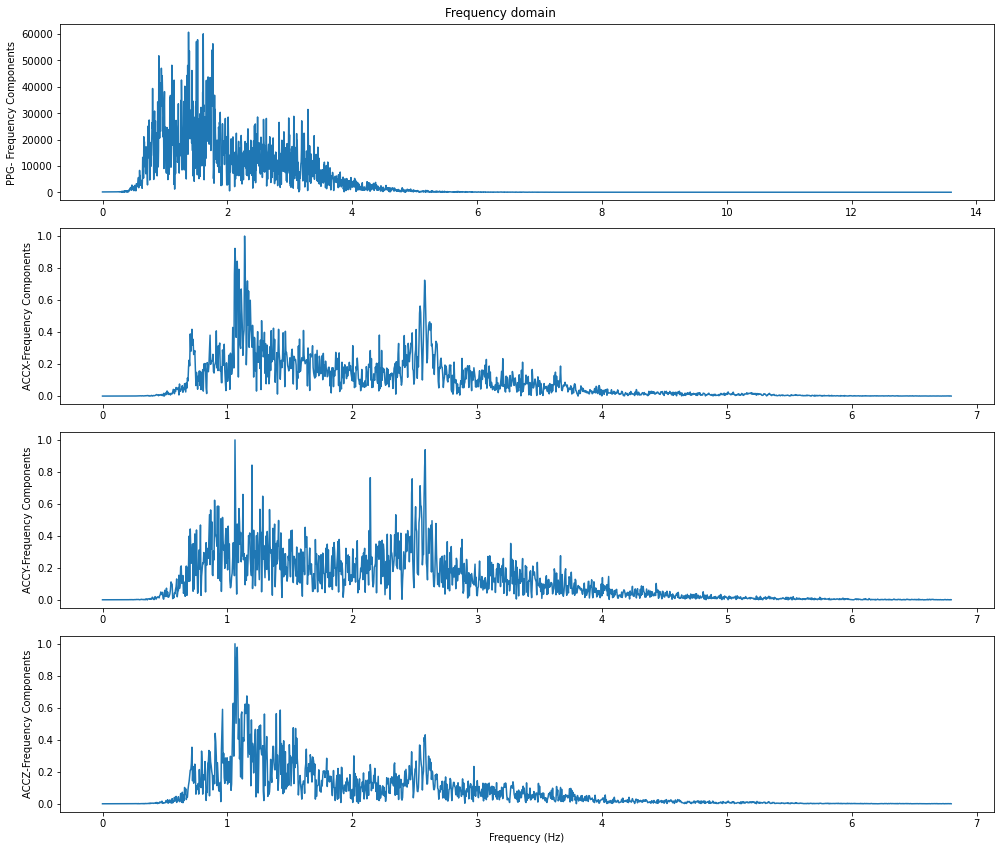

In [101]:
fft_ppg = np.abs(np.fft.rfft(filtered_ppg))
freq_ppg = np.fft.rfftfreq(len(filtered_ppg), 1/fs)

fft_accx = np.abs(np.fft.rfft(filtered_accx))
freq_accx = np.fft.rfftfreq(len(filtered_accx), 1/fs)
        
fft_accy = np.abs(np.fft.rfft(filtered_accy))
freq_accy = np.fft.rfftfreq(len(filtered_accy), 1/fs)
        
fft_accz = np.abs(np.fft.rfft(filtered_accz))
freq_accz = np.fft.rfftfreq(len(filtered_accz), 1/fs)
        

fig, axs = plt.subplots(4, 1,figsize=(14,12))
axs[0].plot(freq_ppg[:3000],fft_ppg[:3000])
#axs[0].set_xlabel('Frequency (Hz)')
axs[0].set_ylabel('PPG- Frequency Components')

axs[1].plot(freq_accx[:1500],fft_accx[:1500]/max(fft_accx))
#axs[1].set_xlabel('Frequency (Hz)')
axs[1].set_ylabel('ACCX-Frequency Components')

axs[2].plot(freq_accy[:1500],fft_accy[:1500]/max(fft_accy))
#axs[2].set_xlabel('Frequency (Hz)')
axs[2].set_ylabel('ACCY-Frequency Components')

axs[3].plot(freq_accz[:1500],fft_accz[:1500]/max(fft_accz))
axs[3].set_xlabel('Frequency (Hz)')
axs[3].set_ylabel('ACCZ-Frequency Components')

plt.suptitle('Frequency domain')
fig.tight_layout()



In [102]:
len(filtered_ppg[filtered_ppg>=100])

66

In [24]:
ppg_max_freqs = []
distance_bpm = 10 # Hyperparameter that was tested from 5 BPM to 20 BPM
distance_bps = distance_bpm/60 # Conversion 1 Hz = 1 cycles per minute * (1 min/60 s)
count=0
inner=0

In [29]:
filt_ppg_specs.shape, filt_ppg_freqs.shape

((501, 146), (501,))

In [34]:
accx_specs[:,0].shape

(501,)

In [32]:
np.argmax(accx_specs[:,i])

9

In [37]:
sorted_ppg_specs = np.sort(filt_ppg_specs[:,i])[::-1]
sorted_ppg_specs[0]

18572.896196902035

In [38]:
np.argwhere(filt_ppg_specs == (sorted_ppg_specs[f]))

array([[ 21, 145]])

In [25]:
ppg_max_freqs = []
distance_bpm = 10 # Hyperparameter that was tested from 5 BPM to 20 BPM
distance_bps = distance_bpm/60 # Conversion 1 Hz = 1 cycles per minute * (1 min/60 s)
count=0
inner=0
for i in range(filt_ppg_specs.shape[1]):
    accx_max_freq = accx_freqs[np.argmax(accx_specs[:,i])]
    accy_max_freq = accy_freqs[np.argmax(accy_specs[:,i])]
    accz_max_freq = accz_freqs[np.argmax(accz_specs[:,i])]
    sorted_ppg_specs = np.sort(filt_ppg_specs[:,i])[::-1]
    count += 1
    #for f in range(filt_ppg_specs.shape[0]):
    for f in range(10):
        ppg_freq = filt_ppg_freqs[np.argwhere(filt_ppg_specs == (sorted_ppg_specs[f]))[0][0]]
        inner+=1
        if ppg_freq == 0:
            continue
        elif (np.abs(ppg_freq-accx_max_freq)<=distance_bps) or (np.abs(ppg_freq-accy_max_freq)<=distance_bps) or (np.abs(ppg_freq-accz_max_freq)<=distance_bps):
            #if f == (filt_ppg_specs.shape[0]-1):
            if f == 9:
                ppg_max_freqs.append(filt_ppg_freqs[np.argwhere(filt_ppg_specs == (sorted_ppg_specs[0]))[0][0]])
            continue
        else:
            ppg_max_freqs.append(ppg_freq)
            break
ppg_max_freqs

[1.625,
 1.625,
 3.375,
 3.375,
 1.625,
 1.625,
 1.625,
 1.625,
 1.75,
 1.75,
 1.75,
 1.75,
 1.75,
 1.625,
 1.625,
 1.75,
 1.75,
 1.5,
 1.5,
 1.75,
 1.75,
 1.75,
 1.875,
 1.875,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.125,
 2.125,
 2.125,
 2.125,
 2.125,
 2.125,
 2.125,
 2.125,
 2.125,
 2.125,
 2.125,
 2.125,
 2.25,
 2.25,
 2.25,
 2.25,
 2.25,
 2.375,
 2.375,
 2.375,
 2.375,
 2.5,
 2.5,
 2.5,
 2.5,
 2.5,
 2.5,
 2.625,
 2.625,
 2.625,
 2.625,
 2.625,
 2.625,
 2.625,
 2.625,
 2.625,
 2.625,
 2.625,
 2.625,
 2.625,
 2.625,
 2.625,
 2.625,
 2.625,
 4.125,
 2.5,
 2.125,
 2.5,
 2.875,
 2.375,
 2.75,
 1.5,
 3.875,
 2.75,
 2.75,
 3.75,
 3.875,
 3.875,
 2.375,
 2.75,
 2.75,
 2.75,
 2.375,
 2.375,
 2.375,
 2.375,
 2.375,
 2.375,
 2.375,
 2.375,
 2.375,
 2.375,
 2.375,
 2.375,
 2.375,
 2.375,
 2.375,
 2.375,
 2.375,
 2.375,
 2.375,
 2.375,
 2.5,
 2.5,
 2.5,
 2.5,
 2.625,
 2.625,
 2.625,
 2.625,
 2.75,
 2.625,
 2.625,
 2.75,
 2.75,
 2.625,
 2.625,
 2.625,
 4.375,
 1.25,
 2.625,
 1.25,
 1.25,


In [ ]:
i=0
fig, axs = plt.subplots(3, 1)
for ppg,accx,accy,accz,bpm in data:
    ts = np.arange(ppg.shape[0])
    ts2=np.arange(bpm.shape[0])
    fig.clf()
    axs[0].plot(ts,ppg)
    axs[0].set_xlabel('Time')
    axs[0].set_ylabel('ppg')
    axs[0].grid(True)
    
    axs[1].plot(ts, accx, label='x')
    axs[1].plot(ts, accy, label='y')
    axs[1].plot(ts, accz, label='z')
    axs[1].set_xlabel('Time')
    axs[1].set_ylabel('accelerometer')
    axs[1].grid(True)
    
    axs[2].plot(ts2,bpm)
    axs[2].set_xlabel('Time')
    axs[2].set_ylabel('BPM')
    axs[2].grid(True)
    
    plt.title('Subject_{}'.format(str(i)))
    plt.legend()
    fig.tight_layout()
    #plt.ylim((-25, 25))
    plt.draw()
    i+=1
    #plt.show()
    while not plt.waitforbuttonpress():
        pass

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


-----
### Project Write-up

Answer the following prompts to demonstrate understanding of the algorithm you wrote for this specific context.

> - **Code Description** - Include details so someone unfamiliar with your project will know how to run your code and use your algorithm. 
> - **Data Description** - Describe the dataset that was used to train and test the algorithm. Include its short-comings and what data would be required to build a more complete dataset.
> - **Algorithhm Description** will include the following:
>   - how the algorithm works
>   - the specific aspects of the physiology that it takes advantage of
>   - a describtion of the algorithm outputs
>   - caveats on algorithm outputs 
>   - common failure modes
> - **Algorithm Performance** - Detail how performance was computed (eg. using cross-validation or train-test split) and what metrics were optimized for. Include error metrics that would be relevant to users of your algorithm. Caveat your performance numbers by acknowledging how generalizable they may or may not be on different datasets.

Your write-up goes here...

-----
### Next Steps
You will now go to **Test Your Algorithm** (back in the Project Classroom) to apply a unit test to confirm that your algorithm met the success criteria. 